In [207]:
#%load_ext autoreload
#%autoreload 2

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from lightgbm import LGBMClassifier
import json
import pickle
import warnings
import joblib
import os

from datetime import datetime
from IPython.display import display, display_html, HTML
from utils import *

# import sklearn
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


# test the hypothesis
from scipy.stats import chi2_contingency, f_oneway


#set max columns and rows to display
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join('..','data', 'two-years-recid.csv'), index_col=0)

df.head()

,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,compas_screening_date,type_of_assessment,decile_score,score_text,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_case_number,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,NaN,F,False Imprisonment,0,0,0,0,2013-01-05,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,NaN,M,Battery,0,0,0,1,2013-04-03,Risk of Recidivism,3,Low,Risk of Violence,3,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,NaN,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,2014-10-31,Risk of Recidivism,4,Low,Risk of Violence,2,Low,1,15043364TC20A,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1
4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,2014-01-23,F,arrest case no charge,0,1,0,1,2014-01-23,Risk of Recidivism,10,High,Risk of Violence,10,High,1,16000241MM20A,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1
5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,NaN,M,Battery,0,0,0,0,2013-12-09,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


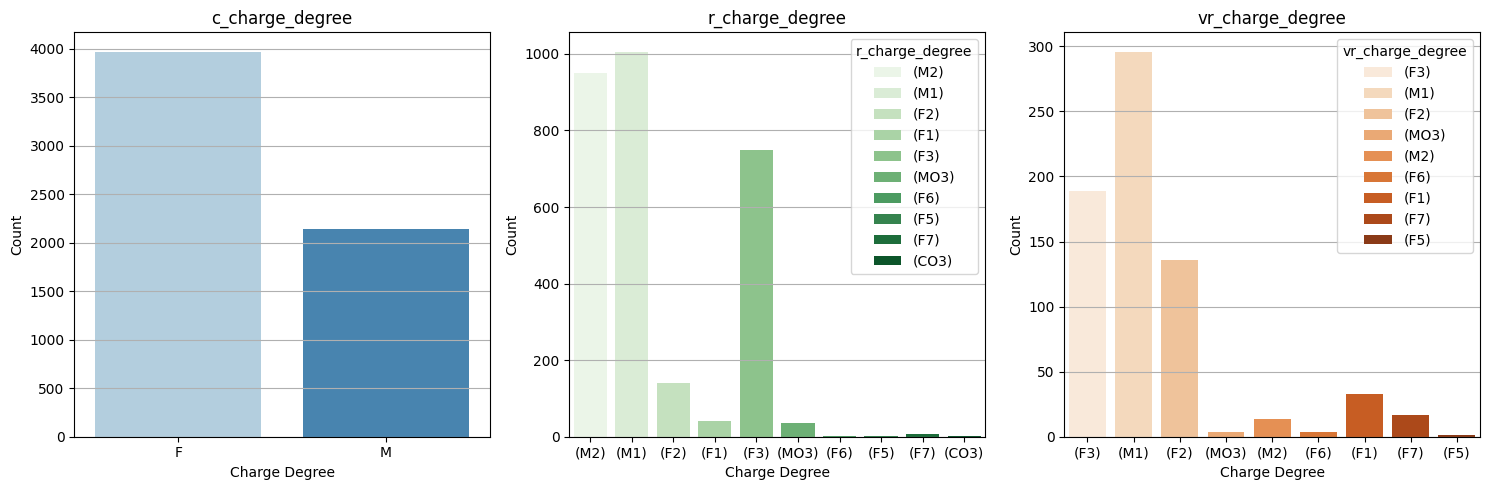

In [3]:
# Create a figure and axis for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for the plots, adjust figsize as needed

# Plot for 'c_charge_degree'
sns.countplot(x='c_charge_degree', data=df, ax=axs[0], hue='c_charge_degree',palette='Blues')
axs[0].set_title('c_charge_degree')
axs[0].set_xlabel('Charge Degree')
axs[0].set_ylabel('Count')
axs[0].grid(True, axis='y')  # Add grid lines only along the y-axis

# Plot for 'r_charge_degree'
sns.countplot(x='r_charge_degree', data=df, ax=axs[1], hue='r_charge_degree', palette='Greens')
axs[1].set_title('r_charge_degree')
axs[1].set_xlabel('Charge Degree')
axs[1].set_ylabel('Count')
axs[1].grid(True, axis='y')  # Add grid lines only along the y-axis

# Plot for 'vr_charge_degree'
sns.countplot(x='vr_charge_degree', data=df, ax=axs[2], hue='vr_charge_degree', palette='Oranges')
axs[2].set_title('vr_charge_degree')
axs[2].set_xlabel('Charge Degree')
axs[2].set_ylabel('Count')
axs[2].grid(True, axis='y')  # Add grid lines only along the y-axis

# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Display the plots
plt.show()

# 1) EDA - Exploratory Data Analysis

Regarding the analysis
- we want you to search for evidence that there is any bias on the previous recidivism scores (for general and violent criminal activity) towards an ethnicity or socio demographic group and whether there are any noticeable trends for specific criminal charge categories.

## 1.1 To analyze potential bias in recidivism based on age, race, and sex, we will:

- Calculate Recidivism Rates: Determine the overall recidivism rates and compare them across different groups.
- Statistical Analysis: Use statistical tests to identify significant differences between groups.

In [4]:
# preprocess data
df = preprocess_data(df)
df.head()

,sex,race,c_charge_degree,juv_fel_count,juv_misd_count,juv_other_count,priors_count,decile_score,score_text,v_decile_score,v_score_text,is_recid,r_charge_degree,is_violent_recid,vr_charge_degree,two_year_recid,age_group,jail_time_days,time_between_arrest_screening
id,,,,,,,,,,,,,,,,,,,
1,Male,Caucasian,Felony,0,0,0,0,1,Low,1,Low,0,Missing,0,Missing,0,55+,1.0,NaN
2,Male,African-American,Misdemeanor,0,0,0,1,3,Low,3,Low,0,Missing,0,Missing,0,25-34,1.0,NaN
3,Male,African-American,Misdemeanor,0,0,0,8,4,Low,2,Low,1,Misdemeanor,0,Missing,1,55+,-1.0,NaN
4,Male,African-American,Felony,0,1,0,1,10,High,10,High,1,Misdemeanor,0,Missing,1,<25,-1.0,0.0
5,Female,Other,Misdemeanor,0,0,0,0,1,Low,1,Low,0,Missing,0,Missing,0,35-44,1.0,NaN


### 1.1.1 Two_year_recid

#### 1.1.1.1 - Calculate Two_year_recid Rates

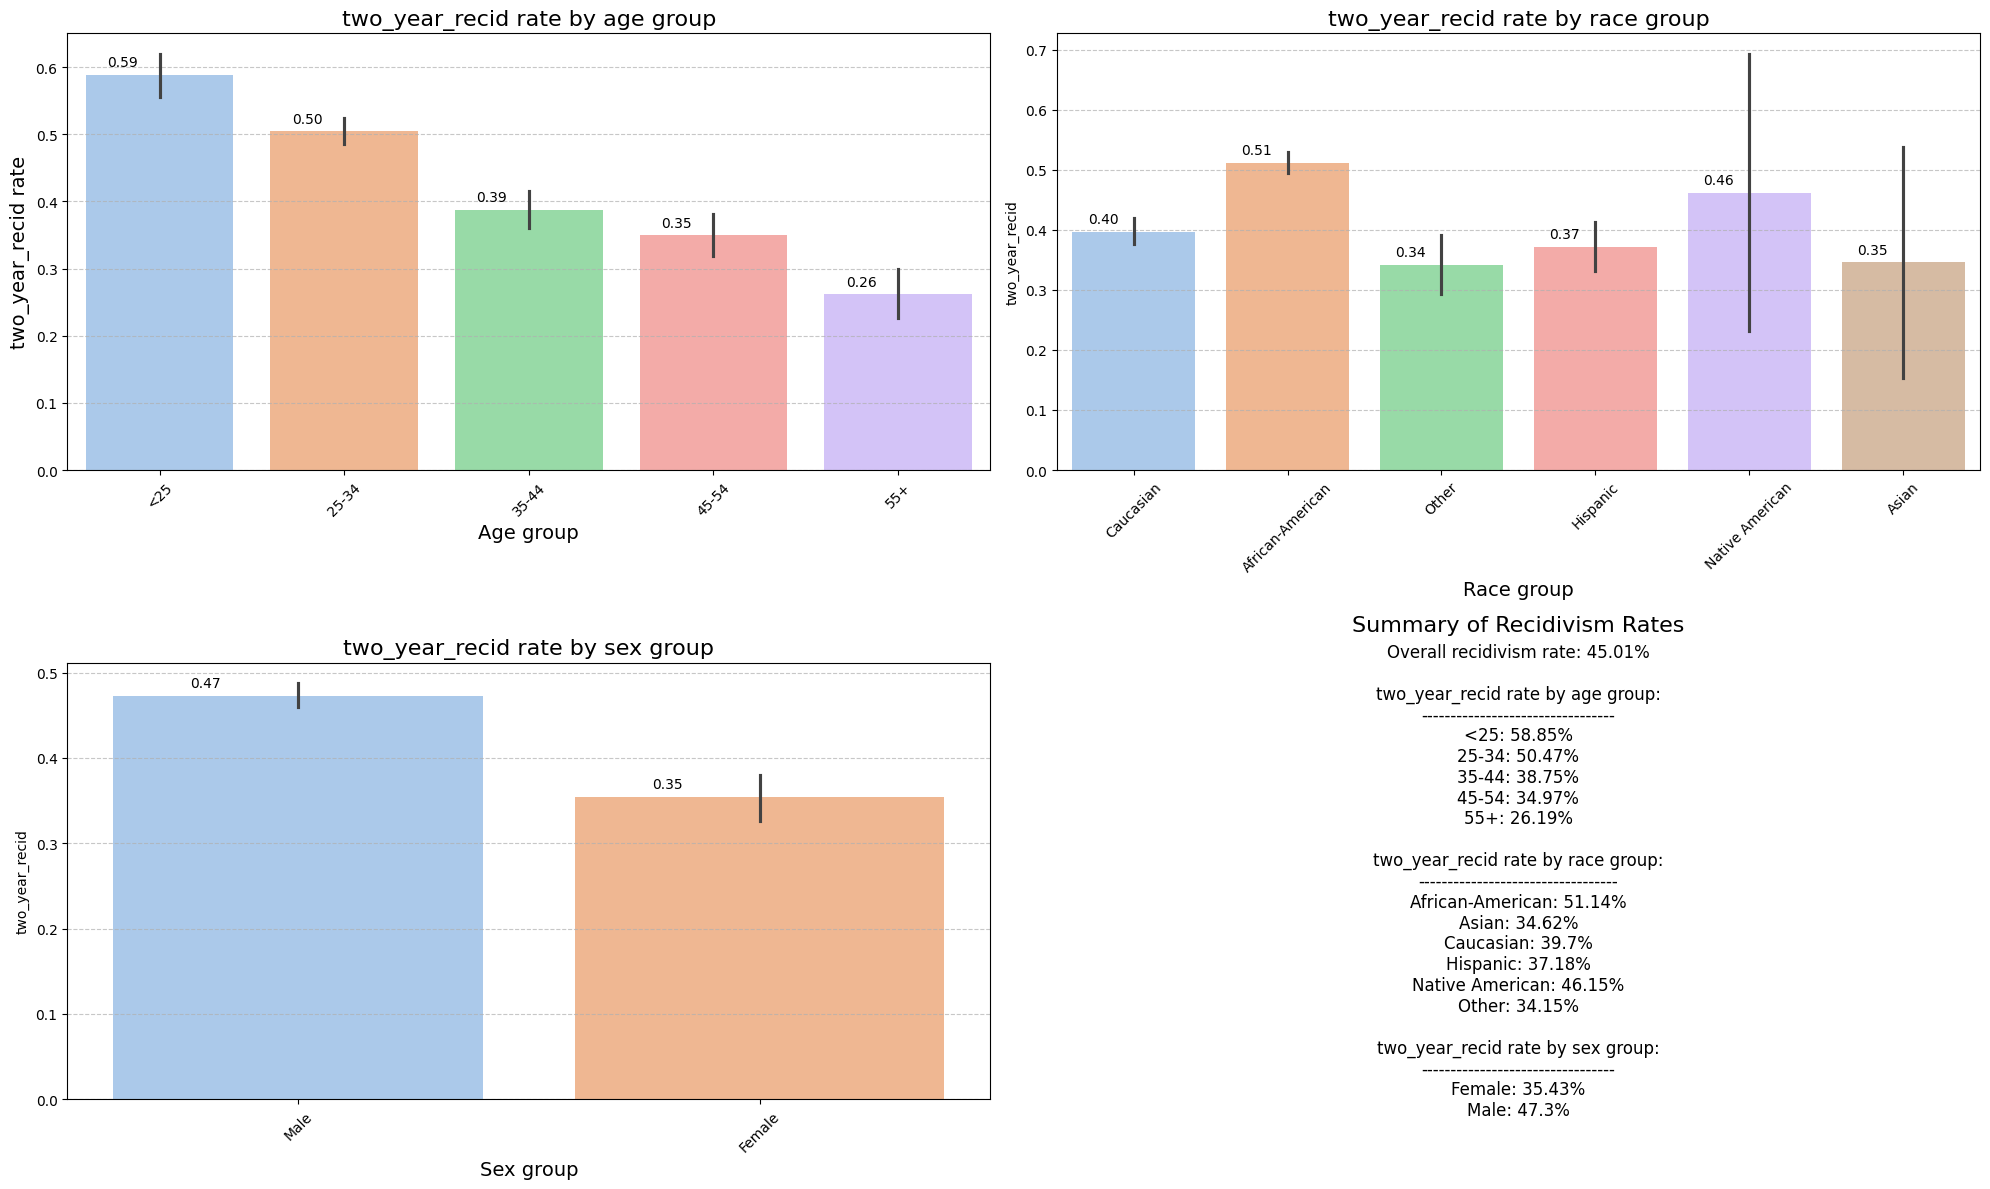

In [5]:
calculate_recid_rate(df, 'two_year_recid')

#### 1.1.1.2 - Statistical Rates for Two_year_recid

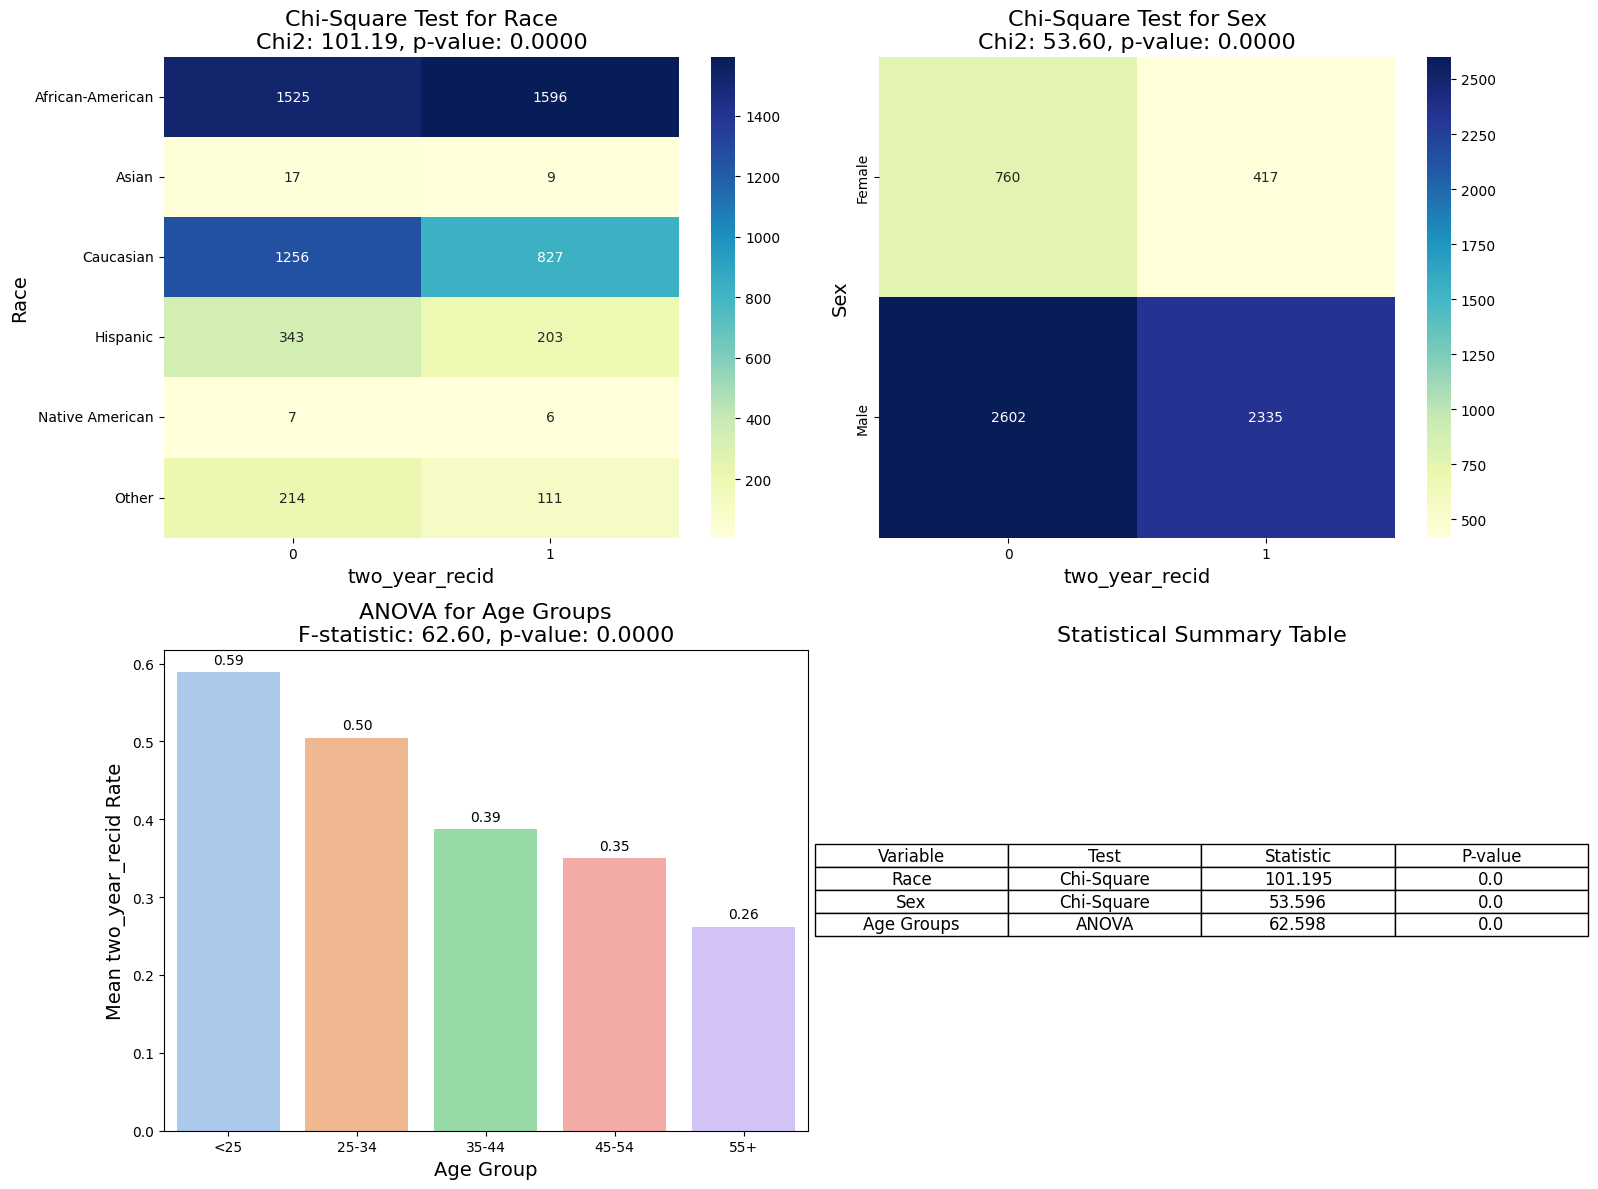

In [6]:
analyze_statistical_recid_rates(df, 'two_year_recid')

### 1.1.2 Previous values - is_recid

#### 1.1.2.1 - Calculate Recidivism Rates - is_recid

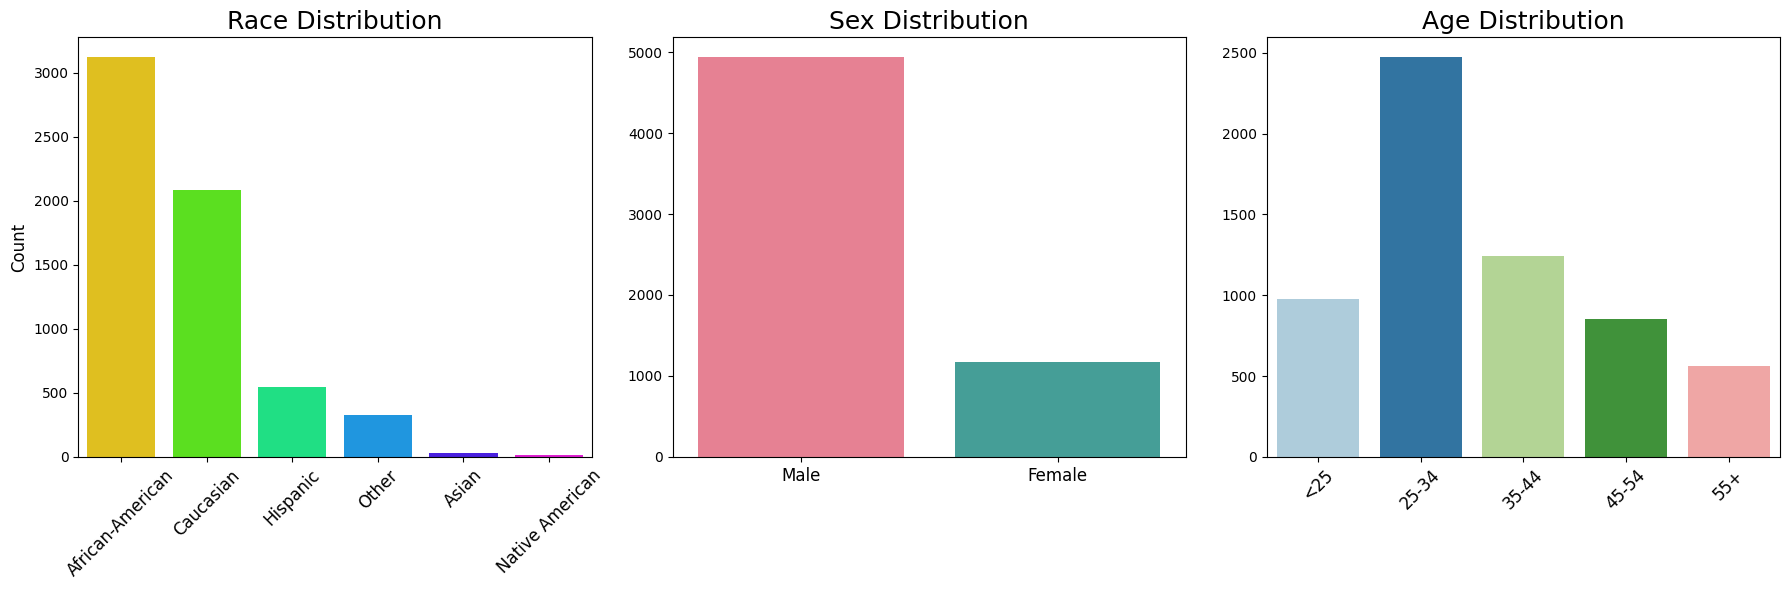

In [7]:
# Create a figure and subplots with better sizing and layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for better spacing

# Define a color palette
palette_race = sns.color_palette("hsv", len(df['race'].unique()))
palette_sex = sns.color_palette("husl", len(df['sex'].unique()))
palette_age = sns.color_palette("Paired", len(df['age_group'].unique()))

# Plot for race distribution (categorical)
race_counts = df['race'].value_counts().sort_values(ascending=False)  # Count and sort races
sns.barplot(x=race_counts.index, y=race_counts.values, ax=axs[0], hue=race_counts.index,palette=palette_race)  # Rotate labels for race plot
axs[0].set_xlabel('')
axs[0].set_ylabel('Count', fontsize=12)
axs[0].set_title('Race Distribution', fontsize=18)
axs[0].tick_params(axis='x', rotation=45, labelsize=12)  # Rotate labels for race plot

# Plot for sex distribution (categorical)
sex_counts = df['sex'].value_counts()  # Count occurrences of sex
sns.barplot(x=sex_counts.index, y=sex_counts.values, ax=axs[1], hue=sex_counts.index, palette=palette_sex)
axs[1].set_xlabel('')
#axs[1].set_ylabel('Count')
axs[1].set_title('Sex Distribution', fontsize=18)
axs[1].tick_params(axis='x', labelsize=12) 

# Handle age distribution (already binned)
# Assuming 'age_group' is a categorical column
age_group_counts = df['age_group'].value_counts().sort_index()  # Sort by index for ordered age groups
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, ax=axs[2], hue=age_group_counts.index ,palette=palette_age)  # Plot on last subplot
axs[2].set_xlabel('')
#axs[2].set_ylabel('Count')
axs[2].set_title('Age Distribution', fontsize=18)
axs[2].tick_params(axis='x', rotation=45, labelsize=12)  # Rotate labels for age plot

# Adjust layout and display the chart
plt.tight_layout()
plt.show()


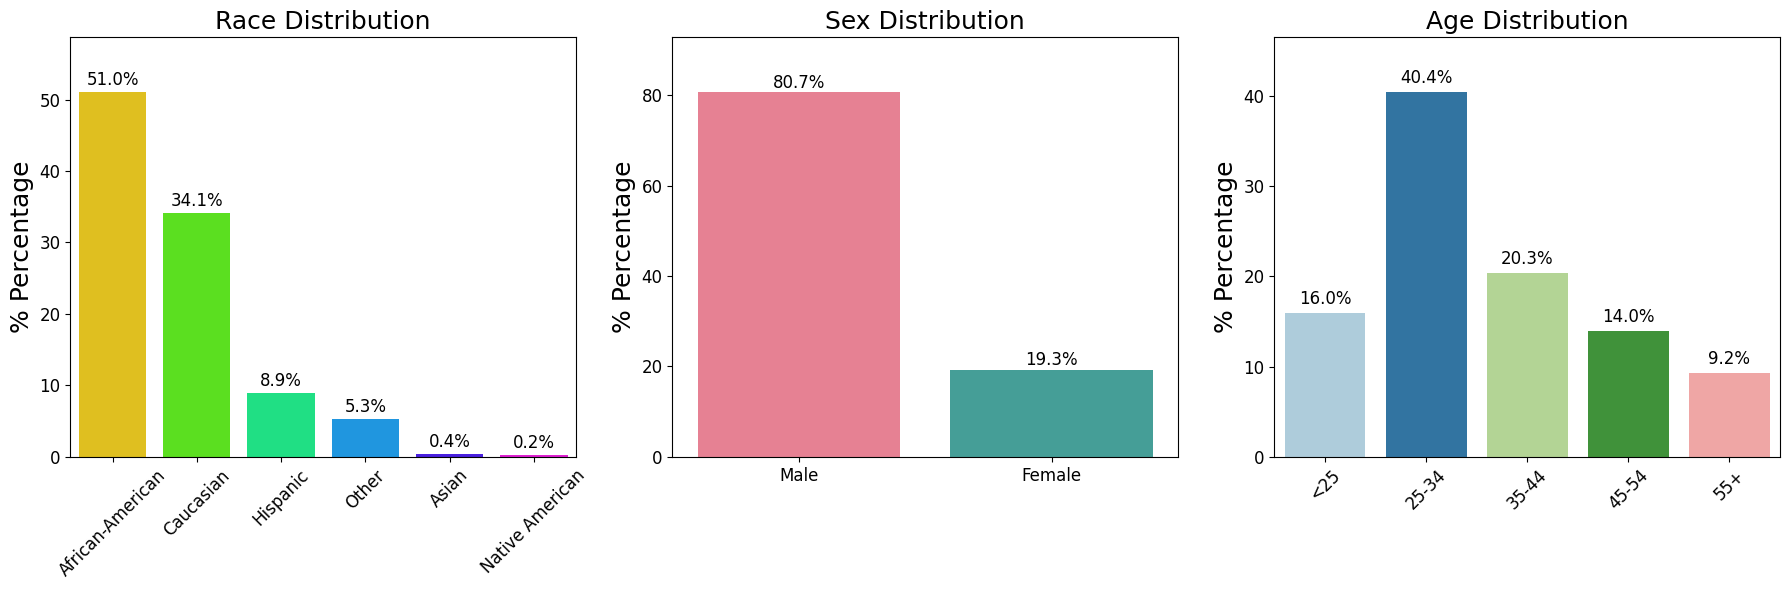

In [8]:
# Calculate the percentage distribution for each categorical variable
race_counts = df['race'].value_counts(normalize=True).sort_values(ascending=False) * 100
sex_counts = df['sex'].value_counts(normalize=True) * 100
age_group_counts = df['age_group'].value_counts(normalize=True).sort_index() * 100

# Create a figure and subplots with better sizing and layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for better spacing

# Define a color palette
palette_race = sns.color_palette("hsv", len(race_counts))
palette_sex = sns.color_palette("husl", len(sex_counts))
palette_age = sns.color_palette("Paired", len(age_group_counts))

# Plot for race distribution (percentage)
sns.barplot(x=race_counts.index, y=race_counts.values, ax=axs[0], hue=race_counts.index, palette=palette_race)
axs[0].set_xlabel('')
axs[0].set_ylabel('% Percentage', fontsize=18)
axs[0].set_title('Race Distribution', fontsize=18)
axs[0].tick_params(axis='x', rotation=45, labelsize=12)  # Rotate labels for race plot
axs[0].tick_params(axis='y',labelsize=12)
axs[0].margins(y=0.15)

# Annotate bars with percentages
for i, v in enumerate(race_counts.values):
    axs[0].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

# Plot for sex distribution (percentage)
sns.barplot(x=sex_counts.index, y=sex_counts.values, ax=axs[1], hue=sex_counts.index, palette=palette_sex)
axs[1].set_xlabel('')
axs[1].set_ylabel('% Percentage', fontsize=18)
axs[1].set_title('Sex Distribution', fontsize=18)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y',labelsize=12)
axs[1].margins(y=0.15)

# Annotate bars with percentages
for i, v in enumerate(sex_counts.values):
    axs[1].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

# Plot for age distribution (percentage)
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, ax=axs[2], hue=age_group_counts.index, palette=palette_age)
axs[2].set_xlabel('')
axs[2].set_ylabel('% Percentage', fontsize=18)
axs[2].set_title('Age Distribution', fontsize=18)
axs[2].tick_params(axis='x', rotation=45, labelsize=12)# Rotate labels for age plot
axs[2].tick_params(axis='y',labelsize=12)
axs[2].margins(y=0.15)

# Annotate bars with percentages
for i, v in enumerate(age_group_counts.values):
    axs[2].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

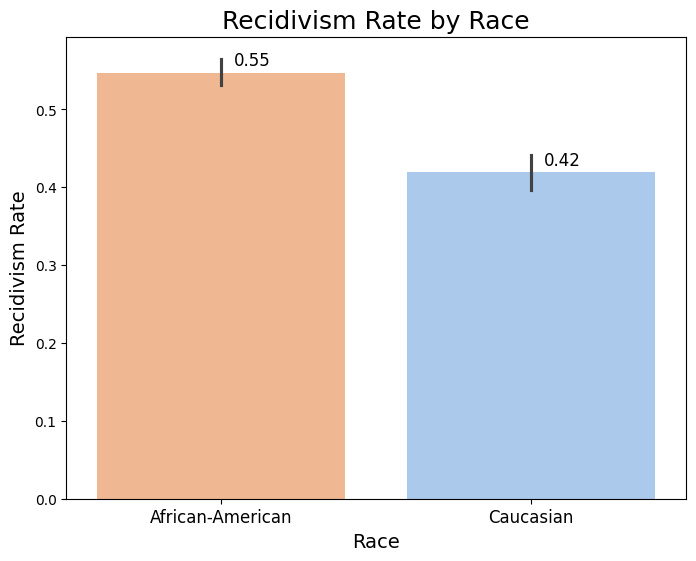

In [9]:
# Create a figure with the desired size
plt.figure(figsize=(8, 6))

# Plotting difference between two classes with hue
ax = sns.barplot(x='race', y='is_recid', data=df, hue='race', order=['African-American', 'Caucasian'])

# Add annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(p.get_x() + 0.1 + p.get_width() / 2, height), 
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                ha='center', fontsize=12)

plt.xlabel('Race', fontsize=14)
plt.ylabel('Recidivism Rate', fontsize=14)
plt.title('Recidivism Rate by Race', fontsize=18)
plt.xticks(fontsize=12)
plt.show()

#### 1.1.2.2 - Correlation Matrix

In [23]:
# select columns that match API input
columns_from_API = ['name',
                      'age',
                      'dob',
                      'race',
                      'juv_fel_count',
                      'juv_misd_count',
                      'juv_other_count',
                      'priors_count',
                      'c_charge_degree',
                      'c_charge_desc',
                      'c_offense_date',
                      'c_arrest_date',
                      'c_jail_in',
                      'is_recid']

df_corr = df.copy()[columns_from_API]

df_corr.head()

,name,age,dob,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,c_offense_date,c_arrest_date,c_jail_in,is_recid
id,,,,,,,,,,,,,,
1,steven lux,62,1953-06-15,Caucasian,0,0,0,0,F,False Imprisonment,2013-01-05,NaN,2013-01-05 04:35:31,0
2,andre small,28,1987-10-01,African-American,0,0,0,1,M,Battery,2013-04-02,NaN,2013-04-02 12:18:46,0
3,willie gray,57,1959-01-12,African-American,0,0,0,8,M,DUI Level 0.15 Or Minor In Veh,2014-10-30,NaN,2014-10-31 12:02:01,1
4,nickson marcellus,19,1996-07-11,African-American,0,1,0,1,F,arrest case no charge,NaN,2014-01-23,2014-01-23 03:19:30,1
5,patria barnes,37,1978-06-06,Other,0,0,0,0,M,Battery,2013-12-07,NaN,2013-12-08 01:55:28,0


Correlation Matrix:
                       age  juv_fel_count  juv_misd_count  juv_other_count  \
age              1.000000      -0.070474       -0.117097        -0.174308   
juv_fel_count   -0.070474       1.000000        0.098465         0.059817   
juv_misd_count  -0.117097       0.098465        1.000000         0.222962   
juv_other_count -0.174308       0.059817        0.222962         1.000000   
priors_count     0.136488       0.173146        0.244094         0.096949   
is_recid        -0.201381       0.094367        0.109390         0.130904   

                 priors_count  is_recid  
age                  0.136488 -0.201381  
juv_fel_count        0.173146  0.094367  
juv_misd_count       0.244094  0.109390  
juv_other_count      0.096949  0.130904  
priors_count         1.000000  0.276157  
is_recid             0.276157  1.000000  

Correlations with recidivism (is_recid):
 is_recid           1.000000
priors_count       0.276157
juv_other_count    0.130904
juv_misd_count    

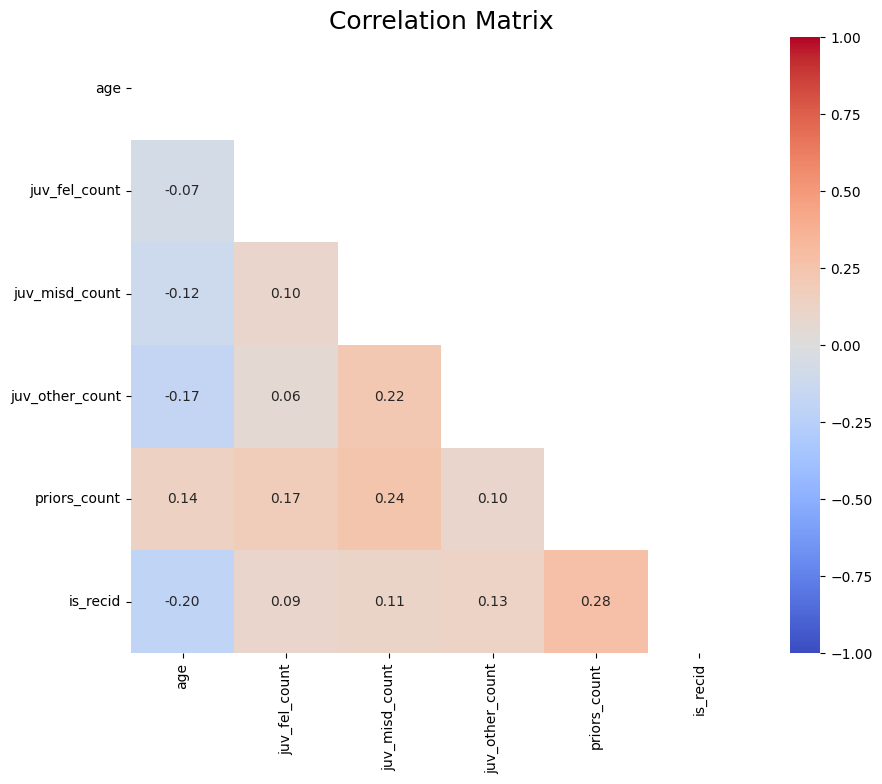

In [28]:
# Select columns to calculate correlation
columns_to_correlate = df_corr.select_dtypes(include=['int64', 'float64']).columns

# Calculate the correlation matrix
correlation_matrix = df_corr[columns_to_correlate].corr()

# Print the correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Identify key predictors of recidivism by focusing on 'is_recid'
recidivism_correlations = correlation_matrix['is_recid'].sort_values(ascending=False)
print("\nCorrelations with recidivism (is_recid):\n", recidivism_correlations)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the correlation matrix
# Create a mask to hide the upper triangular values
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, mask=mask, ax=ax)

# Set the title and display the plot
plt.title('Correlation Matrix', fontsize=18)
plt.show()

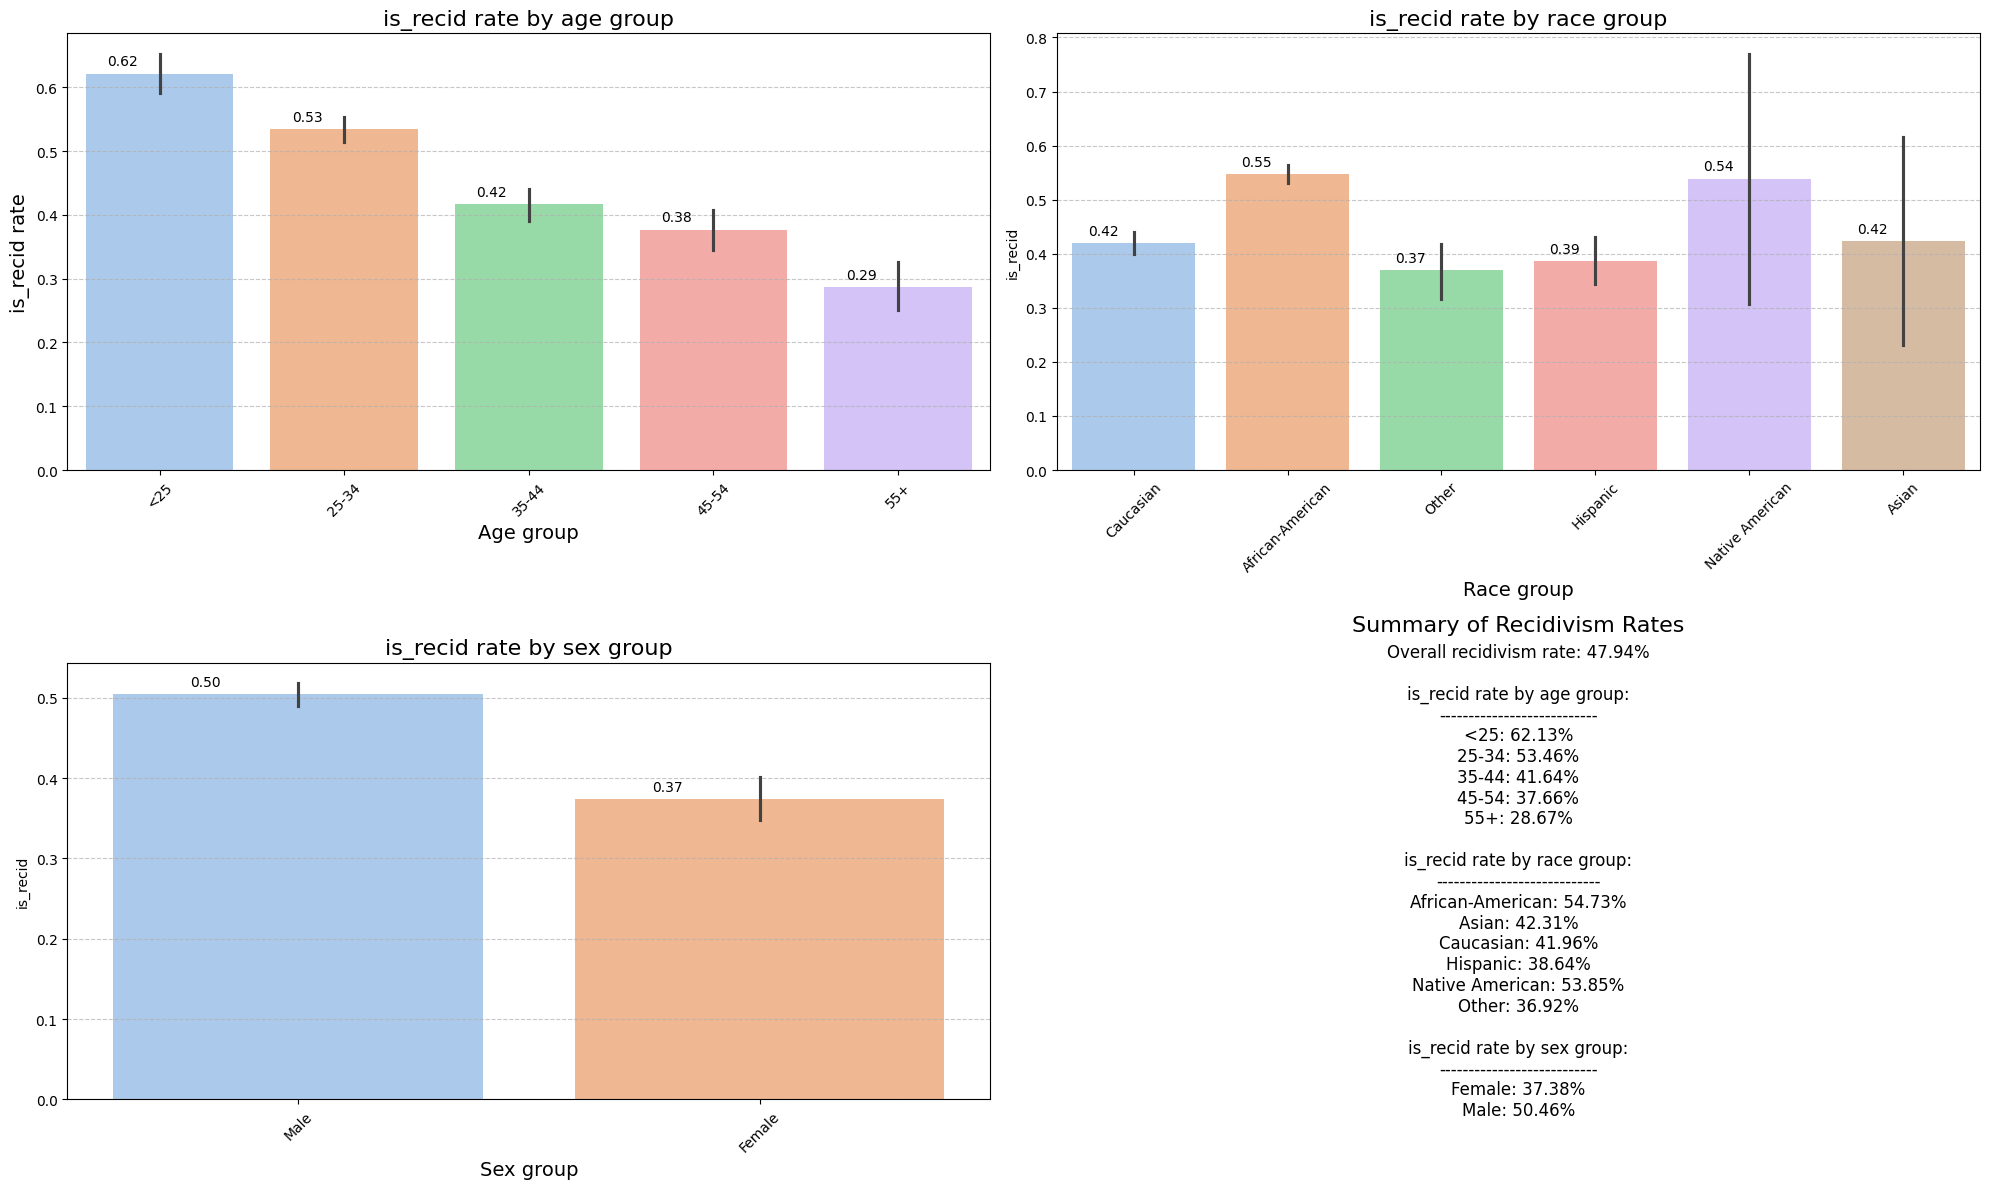

In [10]:
calculate_recid_rate(df, 'is_recid')

#### 1.1.2.3 - Statistical Rates for is_recid

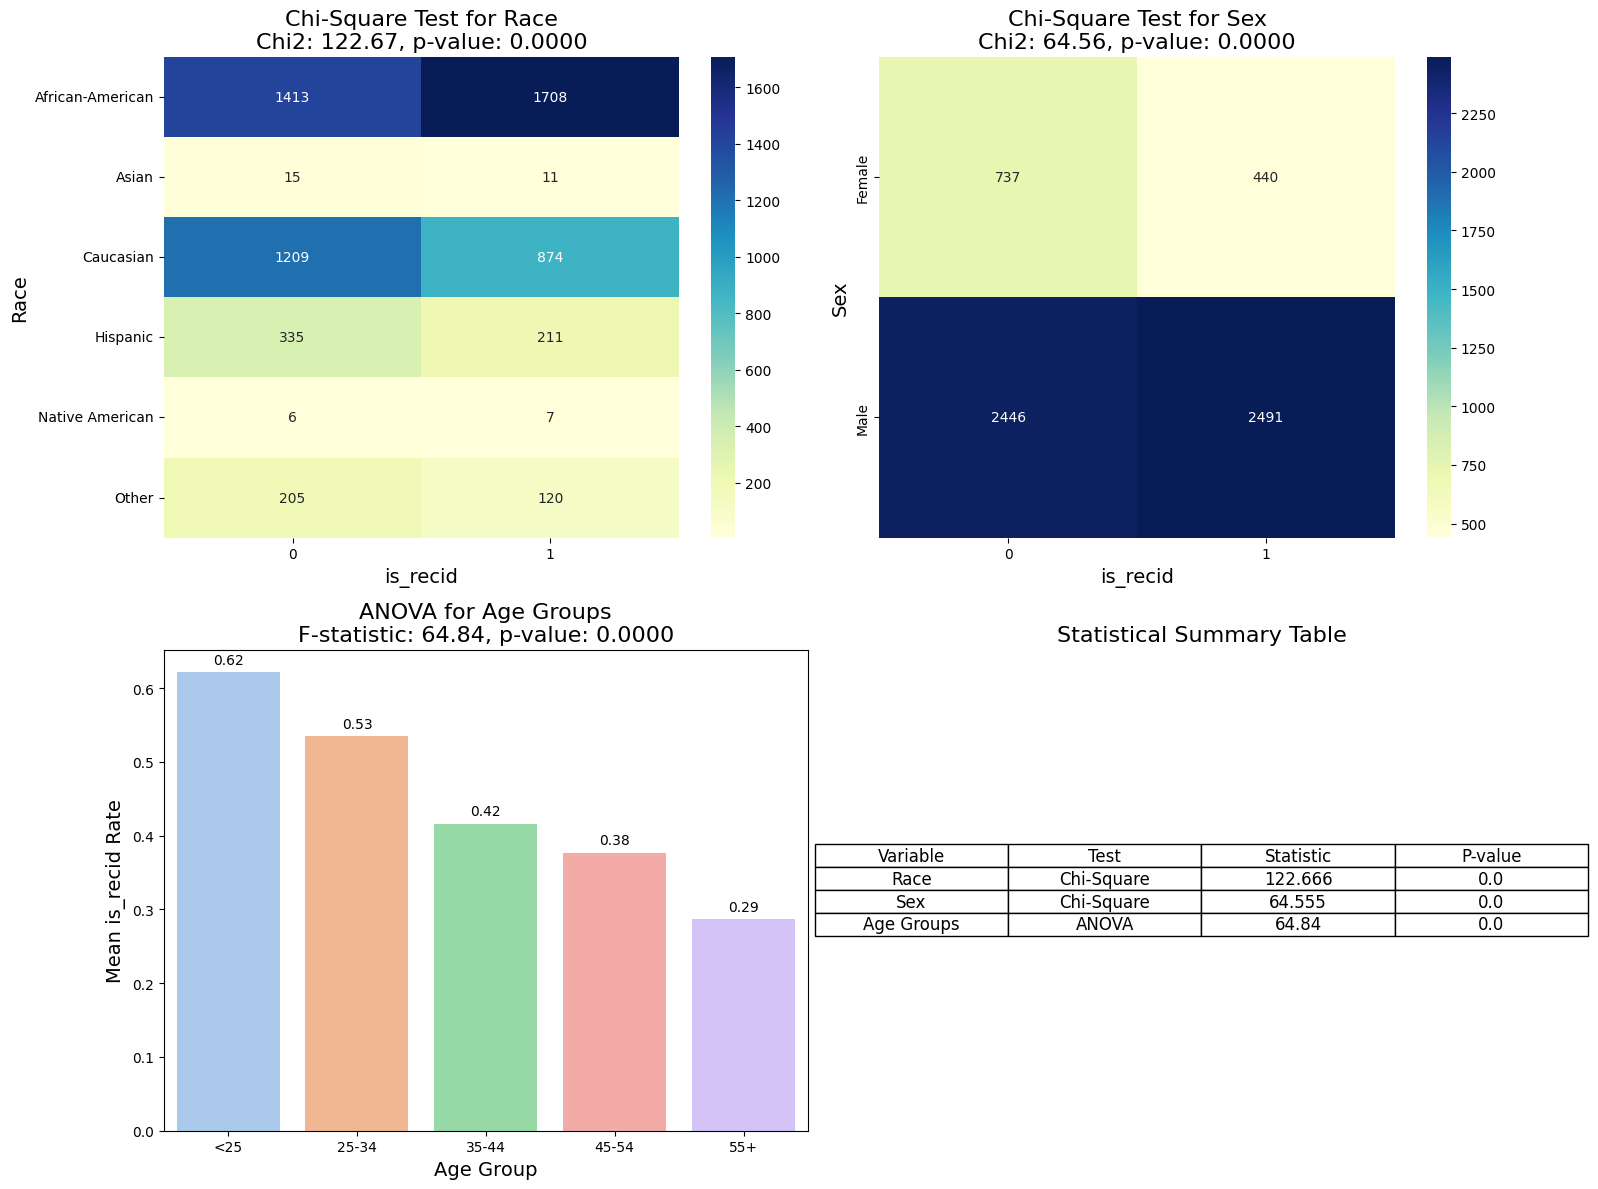

In [11]:
analyze_statistical_recid_rates(df,'is_recid')

### 1.1.3 Previous values - is_violent_recid

#### 1.1.3.1 - Calculate Recidivism Rates - is_violent_recid

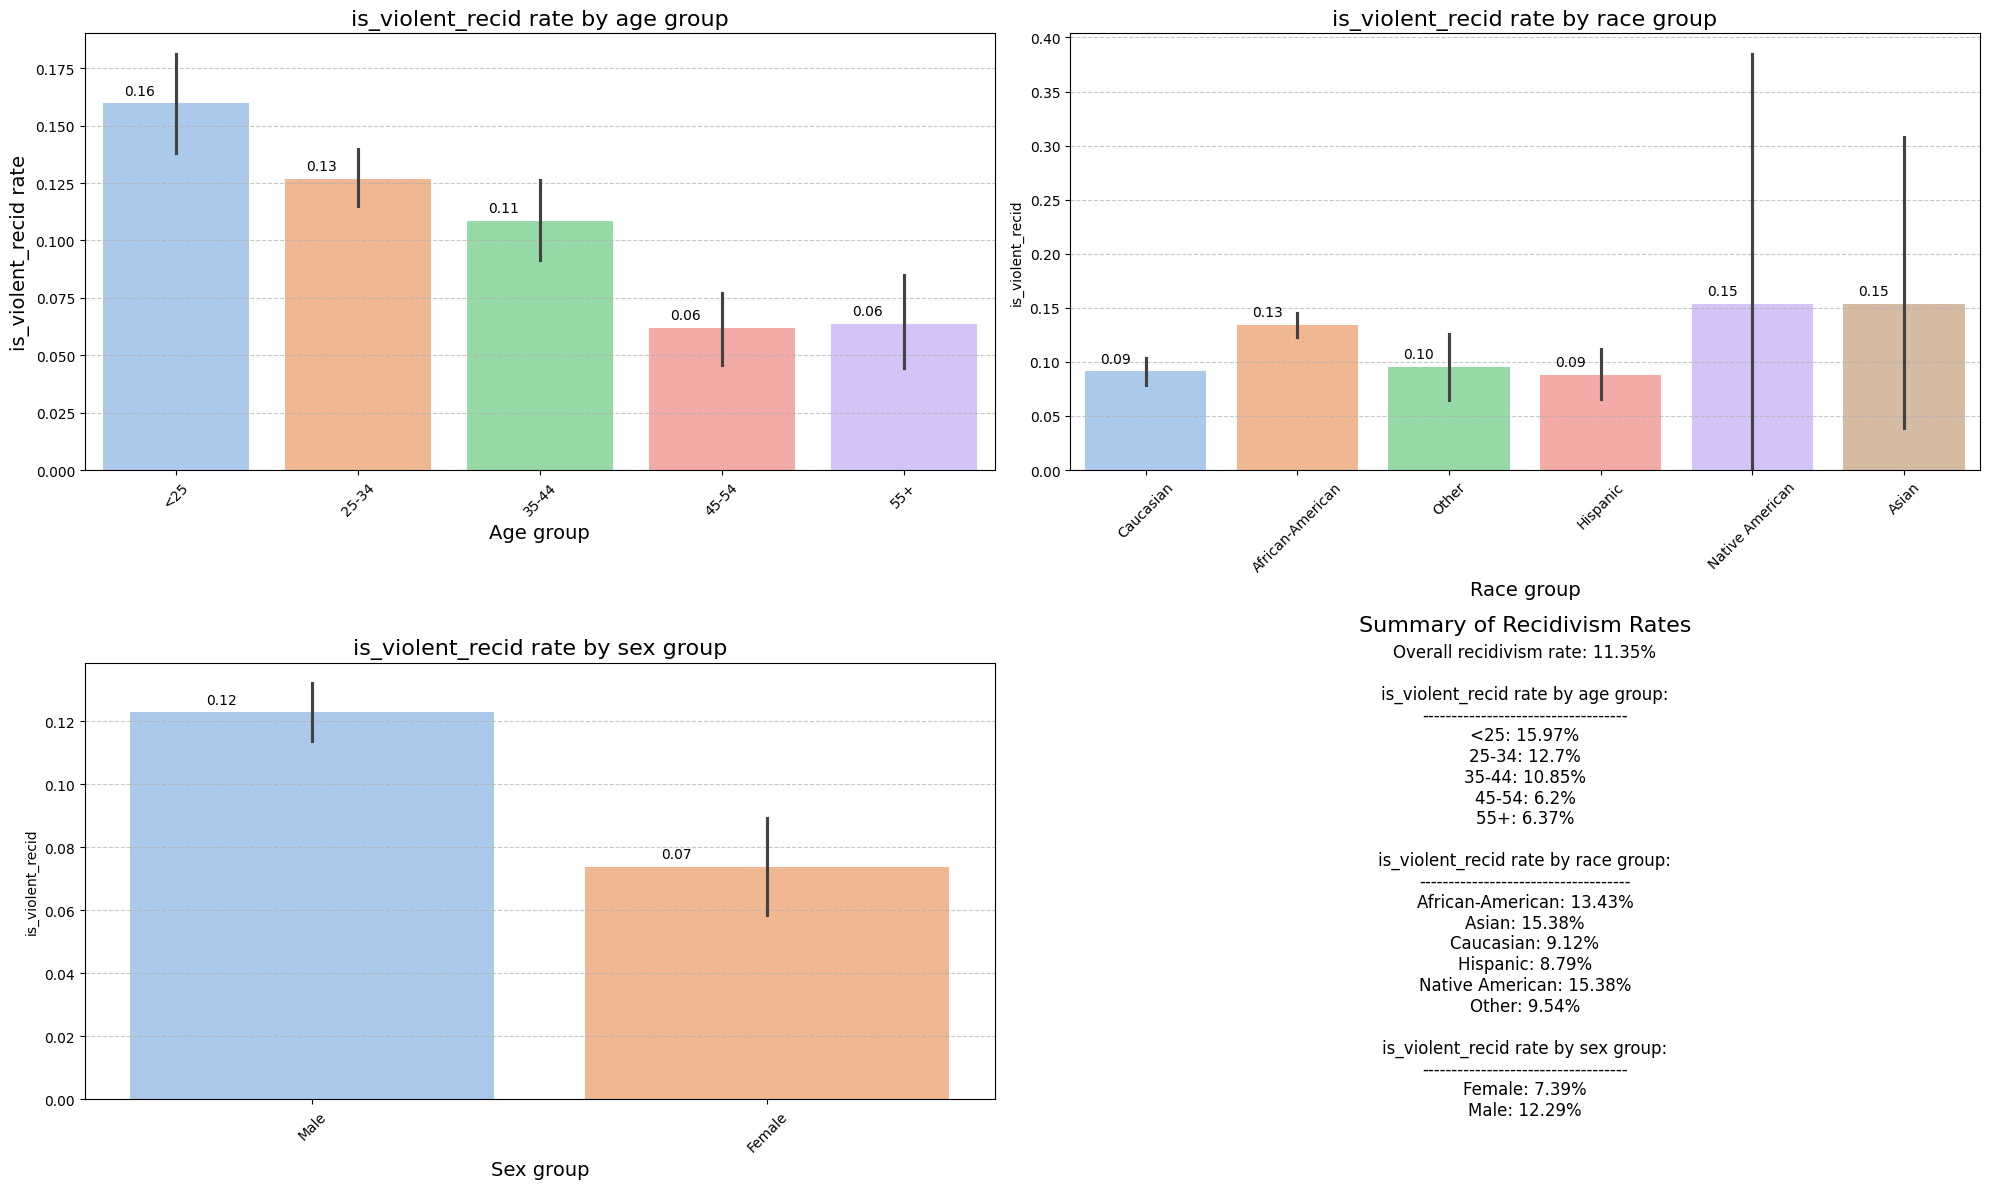

In [12]:
calculate_recid_rate(df, 'is_violent_recid')

#### 1.1.3.2 - Statistical Rates for is_violent_recid

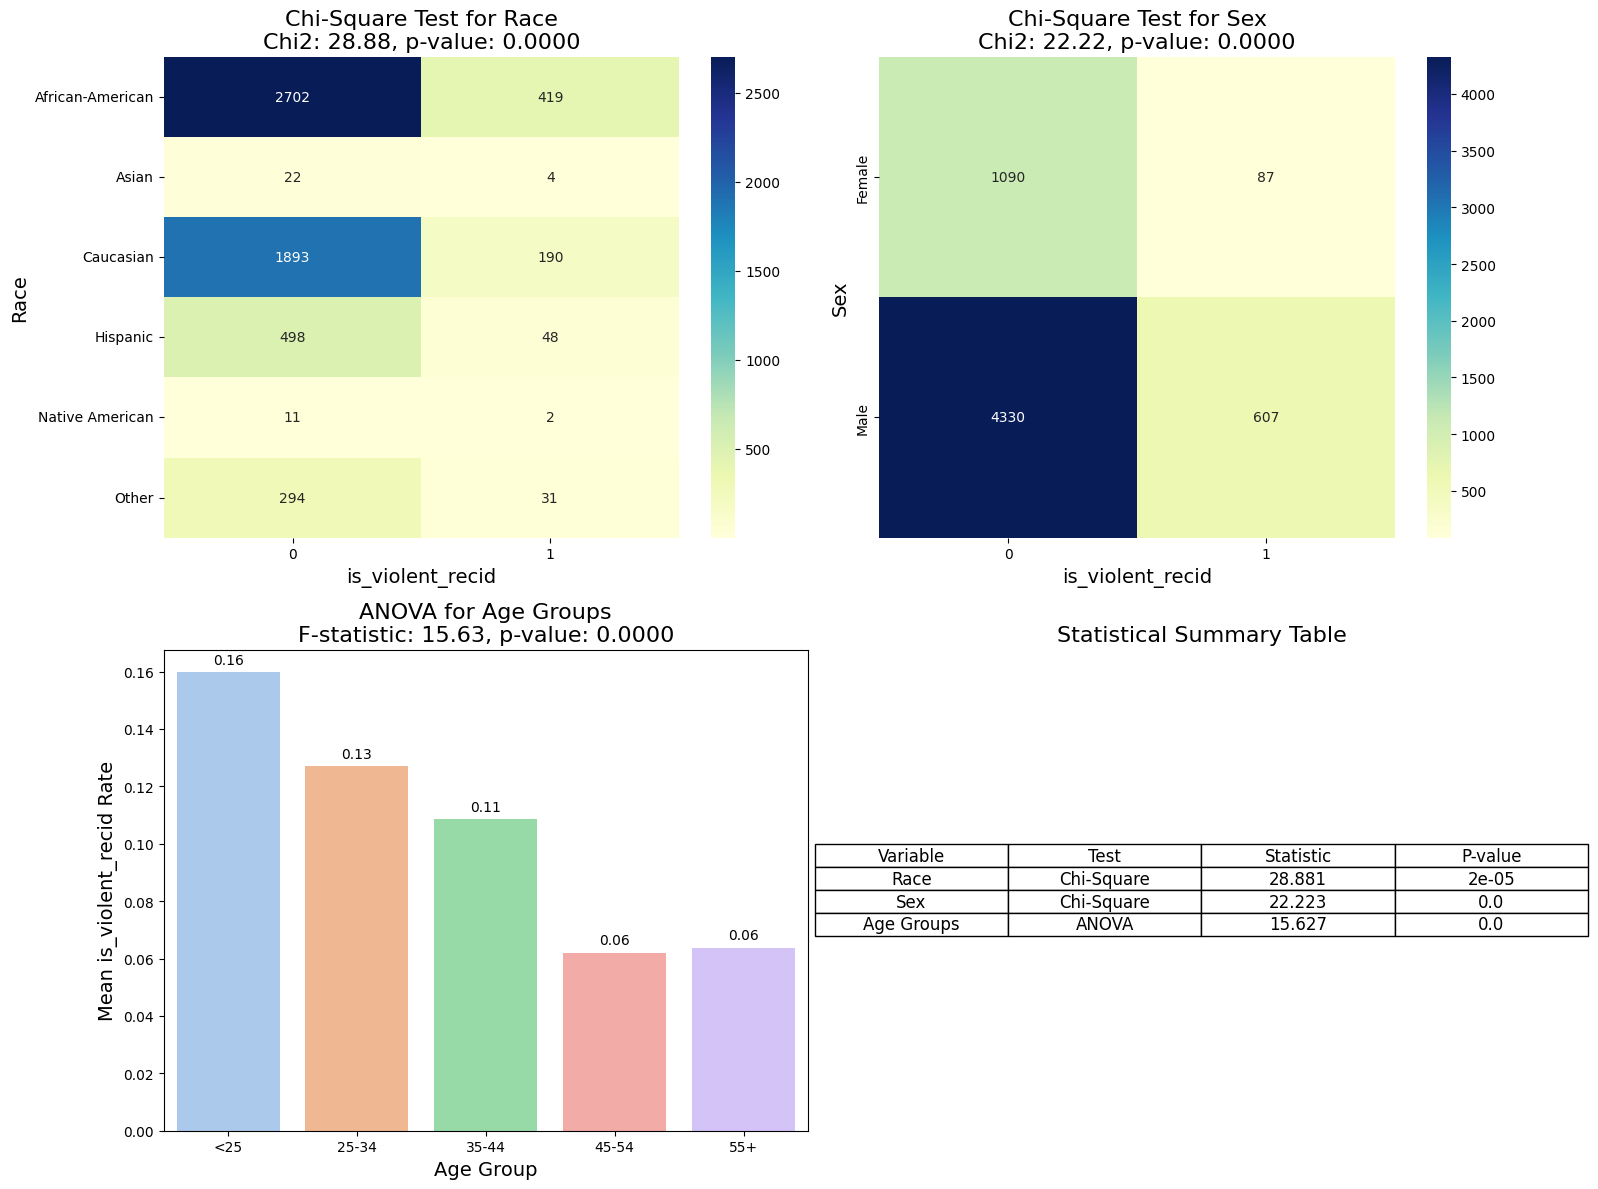

In [13]:
analyze_statistical_recid_rates(df,'is_violent_recid')

## 1.2 To analyze across criminal charge categories

### 1.2.1 Race

In [14]:
display_crosstab_grid(df, 'race')

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
c_charge_degree,,,,,,
Felony,35.23%,0.29%,20.74%,5.22%,0.08%,3.35%
Misdemeanor,15.82%,0.13%,13.33%,3.71%,0.13%,1.96%


race,African-American,Asian,Caucasian,Hispanic,Native American,Other
r_charge_degree,,,,,,
Felony,9.24%,0.05%,4.48%,1.06%,0.05%,0.49%
Misdemeanor,18.69%,0.13%,9.81%,2.39%,0.07%,1.47%
Missing,23.11%,0.25%,19.77%,5.48%,0.10%,3.35%


race,African-American,Asian,Caucasian,Hispanic,Native American,Other
vr_charge_degree,,,,,,
Felony,4.17%,0.05%,1.28%,0.39%,0.03%,0.29%
Misdemeanor,2.68%,0.02%,1.83%,0.39%,0.00%,0.21%
Missing,44.19%,0.36%,30.96%,8.15%,0.18%,4.81%


### 1.2.2 Sex

In [15]:
display_crosstab_grid(df, 'sex')

sex,Female,Male
c_charge_degree,,
Felony,11.45%,53.47%
Misdemeanor,7.80%,27.28%


sex,Female,Male
r_charge_degree,,
Felony,2.04%,13.33%
Misdemeanor,5.15%,27.41%
Missing,12.05%,40.01%


sex,Female,Male
vr_charge_degree,,
Felony,0.64%,5.58%
Misdemeanor,0.79%,4.35%
Missing,17.83%,70.82%


### 1.2.3 Age Group

In [16]:
display_crosstab_grid(df, 'age_group')

age_group,<25,25-34,35-44,45-54,55+
c_charge_degree,,,,,
Felony,11.68%,26.71%,12.69%,8.51%,5.33%
Misdemeanor,4.30%,13.74%,7.65%,5.48%,3.91%


age_group,<25,25-34,35-44,45-54,55+
r_charge_degree,,,,,
Felony,3.03%,6.95%,2.70%,1.77%,0.93%
Misdemeanor,6.90%,14.67%,5.77%,3.50%,1.72%
Missing,6.05%,18.83%,11.87%,8.72%,6.59%


age_group,<25,25-34,35-44,45-54,55+
vr_charge_degree,,,,,
Felony,1.34%,2.94%,1.11%,0.47%,0.34%
Misdemeanor,1.21%,2.19%,1.10%,0.39%,0.25%
Missing,13.43%,35.31%,18.14%,13.12%,8.65%


## 1.3 Fairness Evaluation

### 1.3.1 Fairness Metrics (Disparate Impact Ratio, Equal Opportunity Difference)

#### 1.3.1.1 - Is_recid fairness

In [220]:
# Calculate metrics for race (assuming 'race' column and 'African American' as protected group)
print(calculate_fairness_metrics(df,'is_recid',protected_col='race', protected_val='African-American'))

# Calculate metrics for sex (assuming 'sex' column and 'Female' as protected group)
print(calculate_fairness_metrics(df,'is_recid',protected_col='sex', protected_val='Female'))

# Calculate metrics for age group (assuming 'age_group' column and '<25' as protected group)
print(calculate_fairness_metrics(df,'is_recid',protected_col='age_group', protected_val='<25'))

{'Disparate Impact Ratio': 1.339289171578705, 'Equal Opportunity Difference': 0.13864037983319616}
{'Disparate Impact Ratio': 0.7409102676176291, 'Equal Opportunity Difference': -0.13072564783562607}
{'Disparate Impact Ratio': 1.373306796420952, 'Equal Opportunity Difference': 0.16888553530899209}


#### 1.3.1.2 - Is_violent_recid fairness

In [221]:
# Calculate metrics for race (assuming 'race' column and 'African American' as protected group)
print(calculate_fairness_metrics(df,'is_violent_recid',protected_col='race', protected_val='African-American'))

# Calculate metrics for sex (assuming 'sex' column and 'Female' as protected group)
print(calculate_fairness_metrics(df,'is_violent_recid',protected_col='sex', protected_val='Female'))

# Calculate metrics for age group (assuming 'age_group' column and '<25' as protected group)
print(calculate_fairness_metrics(df,'is_violent_recid',protected_col='age_group', protected_val='<25'))

{'Disparate Impact Ratio': 1.4611482333750838, 'Equal Opportunity Difference': 0.04237078656135919}
{'Disparate Impact Ratio': 0.6011975829986885, 'Equal Opportunity Difference': -0.049032421940408355}
{'Disparate Impact Ratio': 1.5246049472438576, 'Equal Opportunity Difference': 0.05494207934926912}


#### 1.3.1.3 - Two_year_recid fairness

In [222]:
# Calculate metrics for race (assuming 'race' column and 'African American' as protected group)
print(calculate_fairness_metrics(df,'two_year_recid',protected_col='race', protected_val='African-American'))

# Calculate metrics for sex (assuming 'sex' column and 'Female' as protected group)
print(calculate_fairness_metrics(df,'two_year_recid',protected_col='sex', protected_val='Female'))

# Calculate metrics for age group (assuming 'age_group' column and '<25' as protected group)
print(calculate_fairness_metrics(df,'two_year_recid',protected_col='age_group', protected_val='<25'))

{'Disparate Impact Ratio': 1.3240000487821644, 'Equal Opportunity Difference': 0.1251400121590986}
{'Disparate Impact Ratio': 0.7490931650350491, 'Equal Opportunity Difference': -0.11866871777256643}
{'Disparate Impact Ratio': 1.3887511054670842, 'Equal Opportunity Difference': 0.16474813249013864}


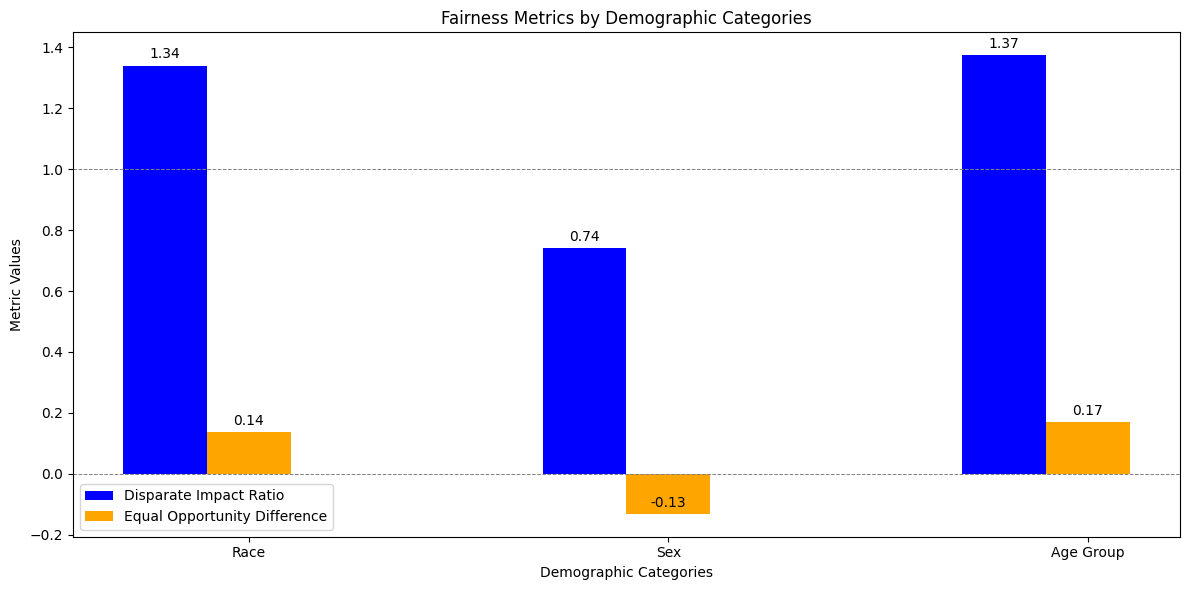

In [223]:
display_fairness_metrics(df, 'is_recid')

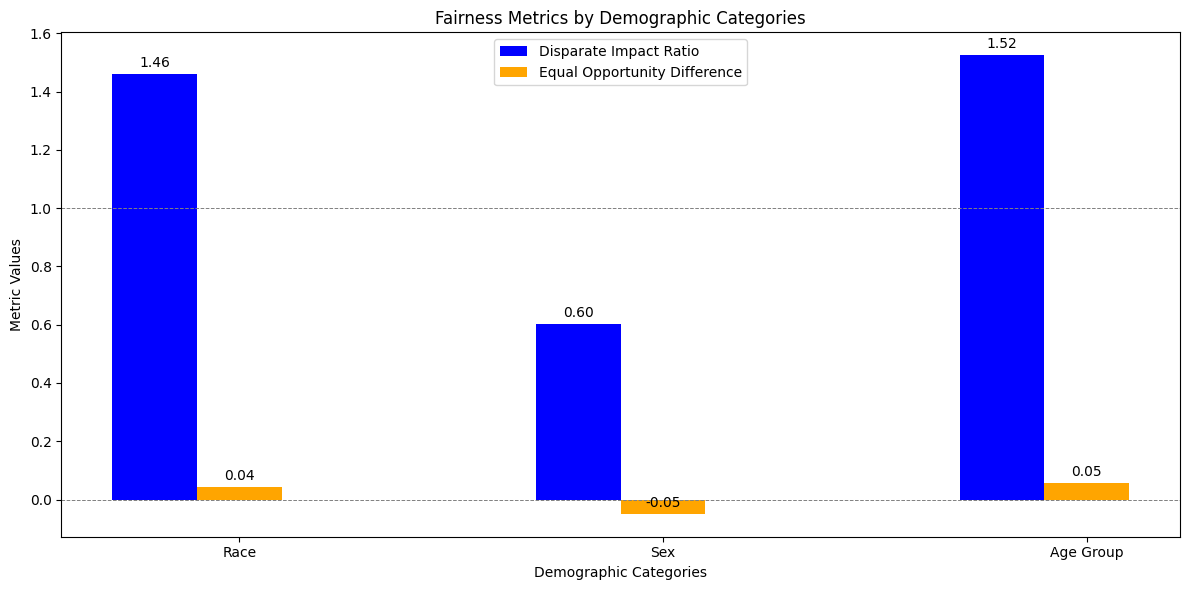

In [224]:
display_fairness_metrics(df, 'is_violent_recid')

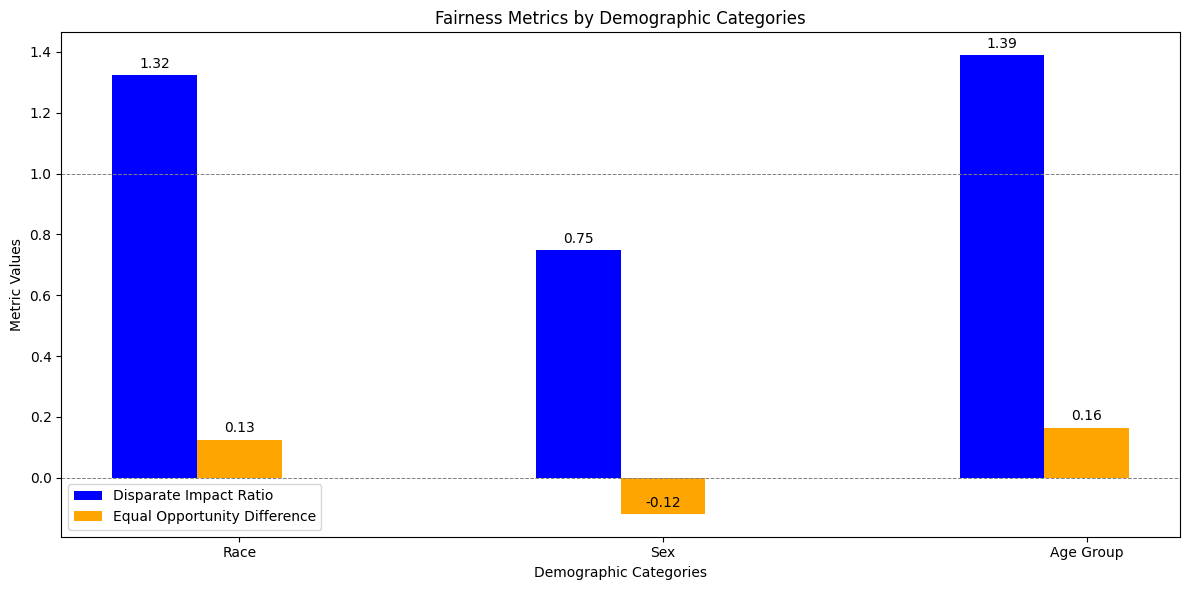

In [225]:
display_fairness_metrics(df, 'two_year_recid')

## 1.4 Correlations

In [67]:
df.columns

Index(['sex', 'race', 'c_charge_degree', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'decile_score', 'score_text',
       'v_decile_score', 'v_score_text', 'is_recid', 'r_charge_degree',
       'is_violent_recid', 'vr_charge_degree', 'two_year_recid', 'age_group',
       'jail_time_days', 'time_between_arrest_screening'],
      dtype='object')

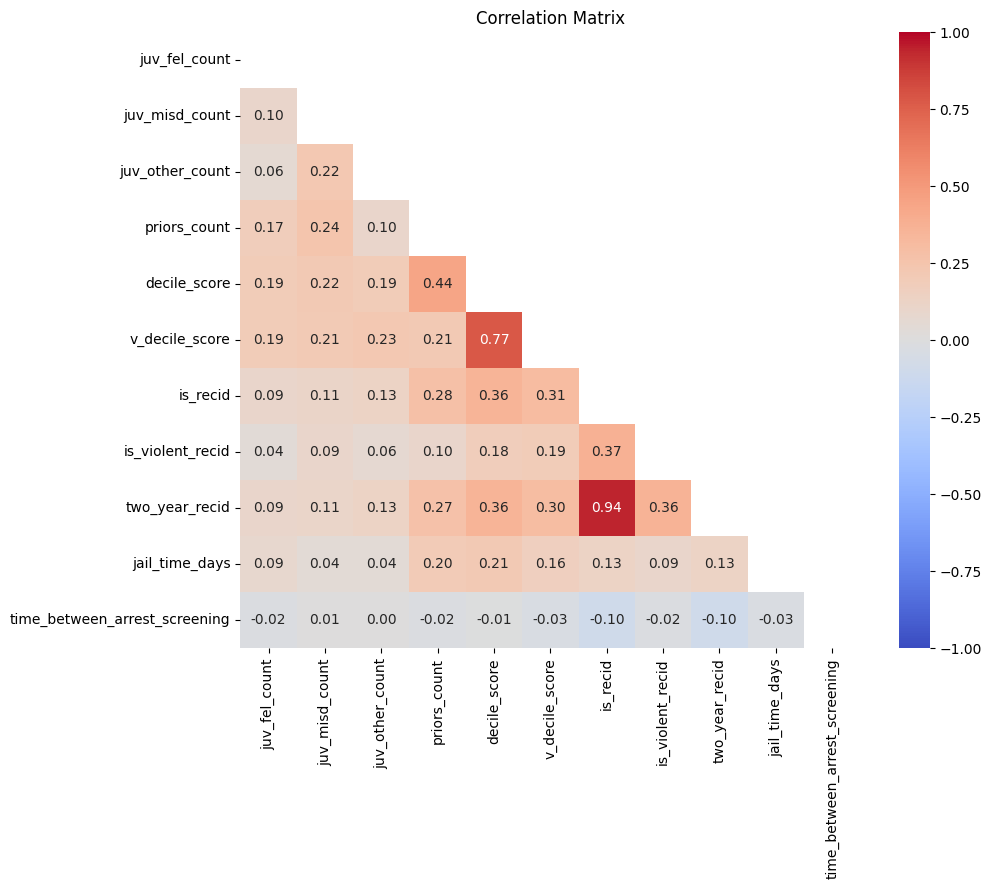

In [73]:
# Correlation matrix
corr = df.select_dtypes(include=['int64', 'float64']).corr()

# Create a mask to hide the upper triangular values
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('Correlation Matrix')
plt.show()

# 2) Baseline Model

## 2.1 - baseline pipeline

In [227]:
# Assuming df is your original DataFrame
df_copy = df.copy()

# Identify categorical columns with low cardinality
cat_cols = df_copy.select_dtypes(include=['object']).columns

# Define features (X) and target (y)
X = df_copy.drop(columns=['is_recid','is_violent_recid','two_year_recid'])
y = df_copy['two_year_recid']

# Define numerical and categorical columns
numerical = X.select_dtypes(include=['int64', 'float64']).columns
categorical = X.select_dtypes(include=['object','category']).columns

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)  # Add handle_unknown='ignore' here
    ])

# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(force_col_wise=True, random_state=42, n_jobs=-1))
    ])

    
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2202, number of negative: 2689
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 4891, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450215 -> initscore=-0.199803
[LightGBM] [Info] Start training from score -0.199803


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
       'decile_score', 'v_decile_score', 'jail_time_days',
       'time_between_arrest_screening'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['sex', 'race', 'c_charge_degree', 'score_text', 'v_score_text',
       'r_charge_degree', 'vr_charge_degree', 'age_group'],
      dtype='object'))])),
                ('classifier',
                 LGBMClassifier(force_col_wise=True, n_jobs=-1,
                                random_state=42))])

## 2.2 - Metrics (accurary,precision,recall,f1)

In [228]:
# Get predictions
df['pred_baseline'] = pipeline.predict(X)
df['pred_baseline_prob'] = pipeline.predict_proba(X)[:, 1]

# Define races
races = ['Caucasian', 'African-American','Asian','Hispanic', 'Native American','Other']

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return cm, accuracy, precision, recall, f1

# Dictionary to hold metrics for each race
race_metrics = {}

# Calculate metrics for each race
for race in races:
    race_data = df[df['race'] == race]
    y_true = race_data['two_year_recid']
    y_pred = race_data['pred_baseline']
    
    cm, accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
    
    race_metrics[race] = {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

## 2.3 - Confusion Matrix

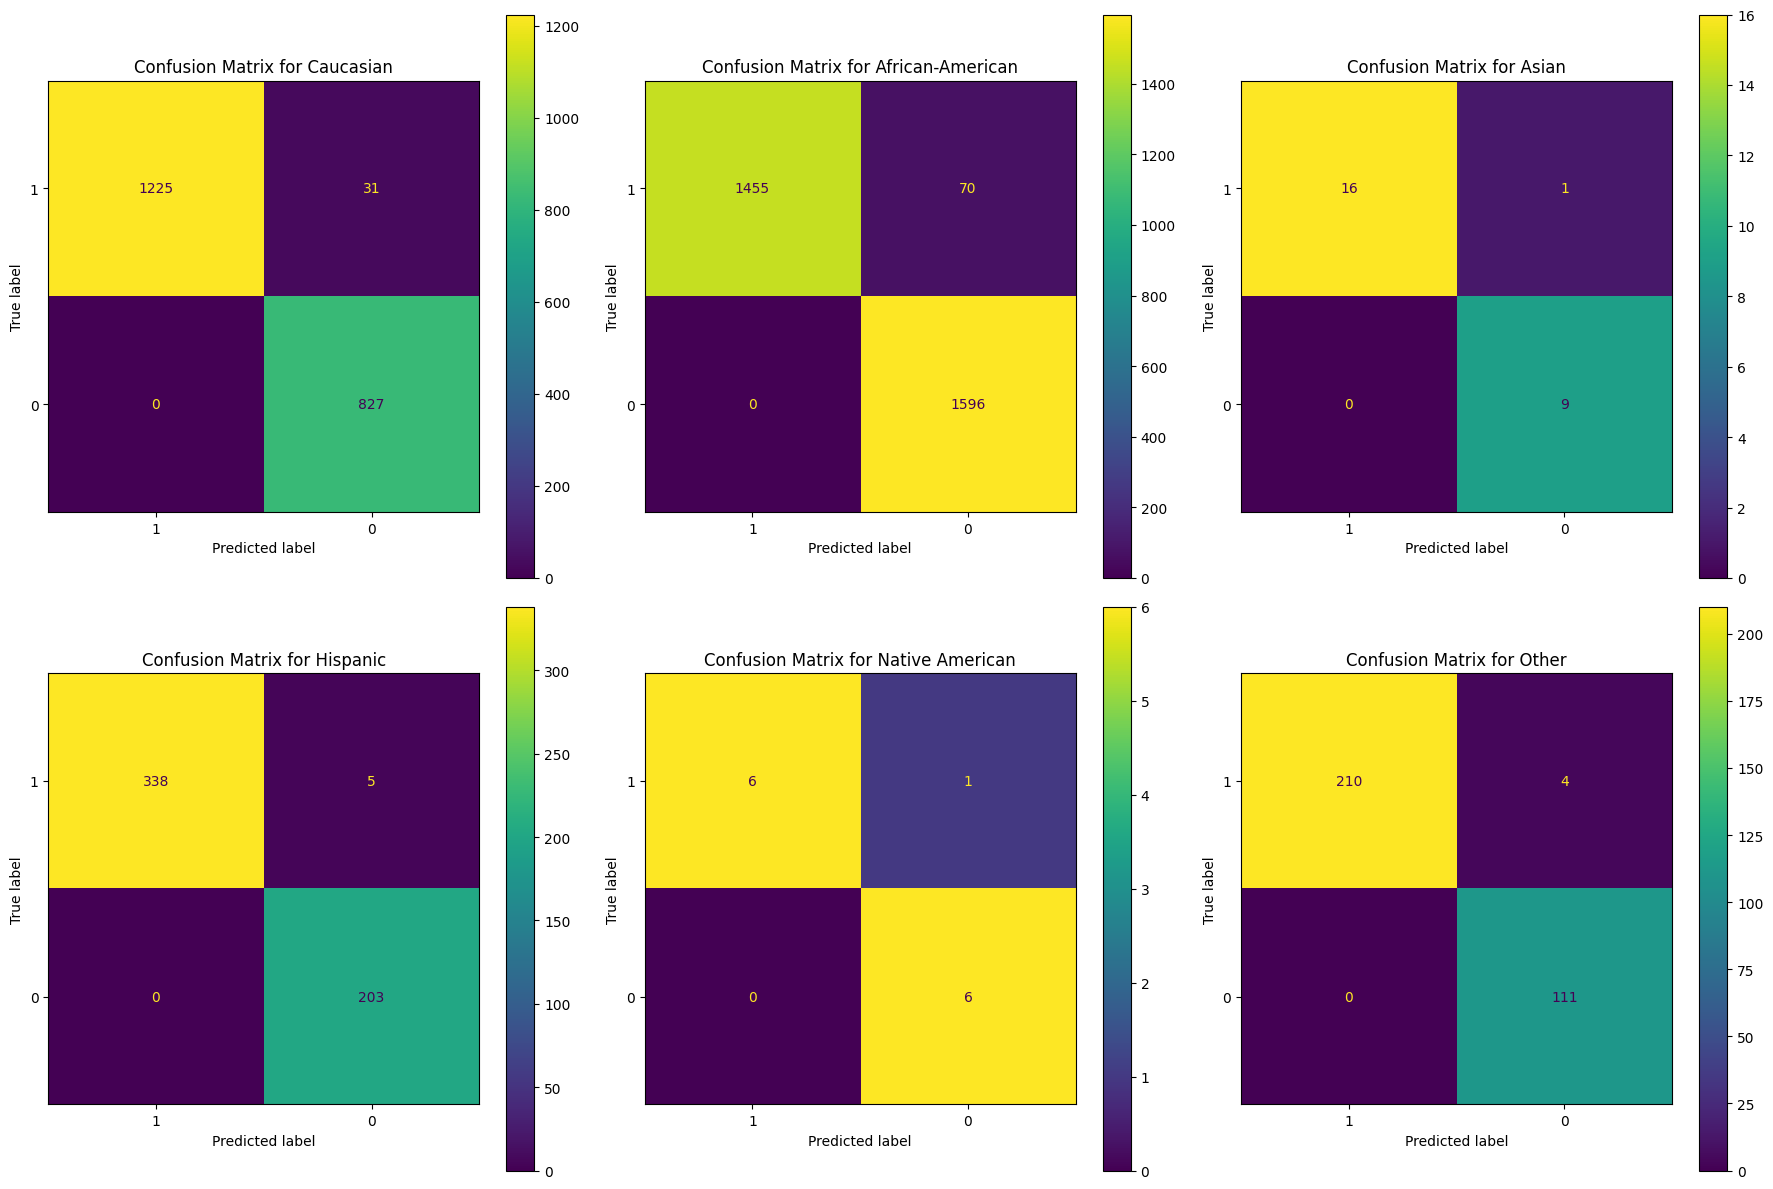

In [229]:
# Plot confusion matrices side by side
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for ax, race in zip(axes.flatten(), races):
    ConfusionMatrixDisplay(race_metrics[race]['confusion_matrix'], display_labels=[1,0]).plot(ax=ax, cmap='viridis')
    ax.set_title(f'Confusion Matrix for {race}')

plt.tight_layout()
plt.show()

## 2.4 - Fairness Metric for Model

In [230]:
# Calculate metrics for race (assuming 'race' column and 'African American' as protected group)
print(calculate_fairness_metrics(df,'pred_baseline',protected_col='race', protected_val='African-American'))

# Calculate metrics for sex (assuming 'sex' column and 'Female' as protected group)
print(calculate_fairness_metrics(df,'pred_baseline',protected_col='sex', protected_val='Female'))

# Calculate metrics for age group (assuming 'age_group' column and '<25' as protected group)
print(calculate_fairness_metrics(df,'pred_baseline',protected_col='age_group', protected_val='<25'))

{'Disparate Impact Ratio': 1.3336170130822544, 'Equal Opportunity Difference': 0.1335359778391383}
{'Disparate Impact Ratio': 0.747118691693633, 'Equal Opportunity Difference': -0.1245198421091307}
{'Disparate Impact Ratio': 1.3817141701822697, 'Equal Opportunity Difference': 0.1685278835844633}


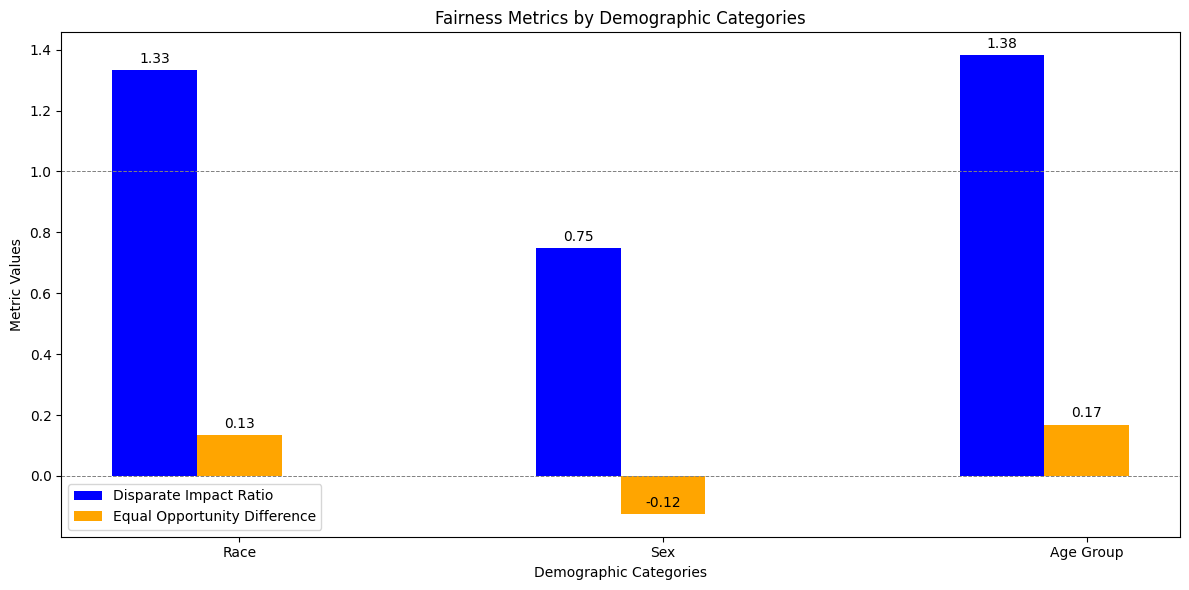

In [231]:
display_fairness_metrics(df, 'pred_baseline')

## 2.5 - Feature Importance 

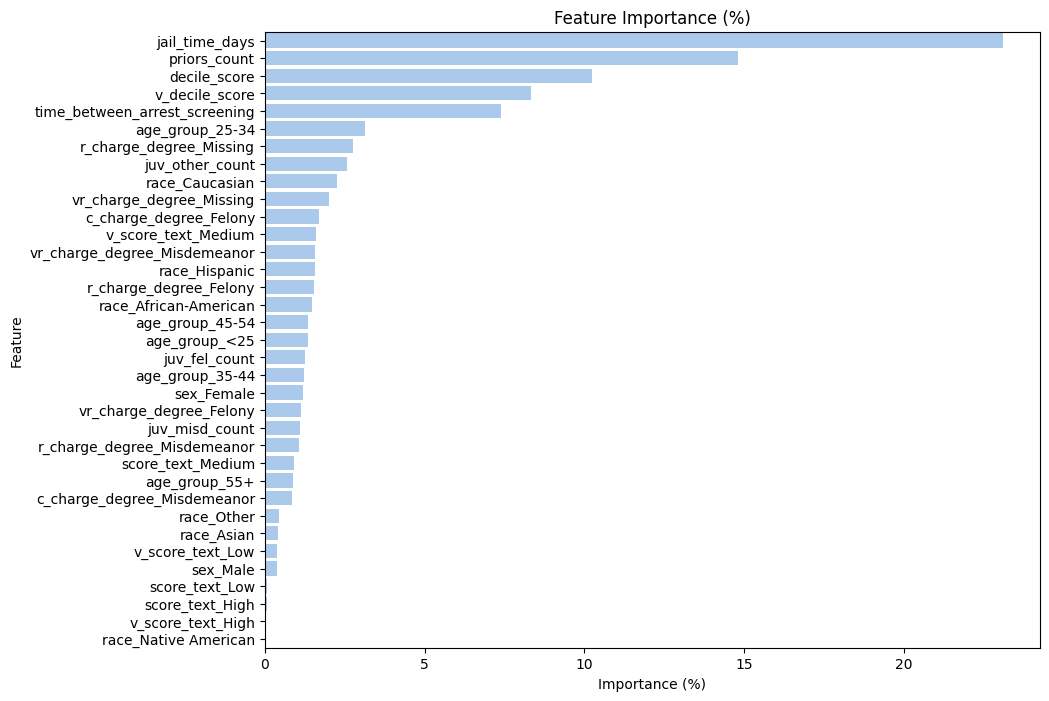

In [232]:
# Extracting feature names from the preprocessor pipeline
feature_names_num = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
feature_names_cat = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()

# Concatenating numerical and categorical feature names
feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Extracting feature importances from the classifier
feature_importance = pipeline.named_steps['classifier'].feature_importances_

# Converting feature importances to percentages
feature_importance_percent = 100 * (feature_importance / feature_importance.sum())

# Creating a DataFrame with feature names and their percentage importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_percent})

# Sorting the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plotting the top 40 features by importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance (%)')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.show()


## 2.6 ROC Curve

Judges use COMPAS deciles to make decisions, as well the text descriptors (“Low, Medium, High Risk”) offered by Northpointe. These text descriptors correspond to score thresholds of 4 and 7.

In [233]:
df.columns

Index(['sex', 'race', 'c_charge_degree', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'decile_score', 'score_text',
       'v_decile_score', 'v_score_text', 'is_recid', 'r_charge_degree',
       'is_violent_recid', 'vr_charge_degree', 'two_year_recid', 'age_group',
       'jail_time_days', 'time_between_arrest_screening', 'pred_baseline',
       'pred_baseline_prob'],
      dtype='object')

In [234]:
df[['score_text', 'decile_score']].\
    value_counts().\
    unstack().\
    fillna(0).\
    reindex(['Low', 'Medium', 'High']).\
    style.background_gradient(cmap='viridis').format("{:.0f}")

decile_score,1,2,3,4,5,6,7,8,9,10
score_text,,,,,,,,,,
Low,1221,805,640,658,0,0,0,0,0,0
Medium,0,0,0,0,583,541,503,0,0,0
High,0,0,0,0,0,0,0,420,410,333


In [235]:
df[['v_score_text', 'v_decile_score']].\
    value_counts().\
    unstack().\
    fillna(0).\
    reindex(['Low', 'Medium', 'High']).\
    style.background_gradient(cmap='viridis').format("{:.0f}")

v_decile_score,1,2,3,4,5,6,7,8,9,10
v_score_text,,,,,,,,,,
Low,1606,918,832,688,0,0,0,0,0,0
Medium,0,0,0,0,589,515,369,0,0,0
High,0,0,0,0,0,0,0,240,246,111


What if we could provide judges with an interpretation of these scores that are more sensitive to race? To this aim, we will analyze the scores of the COMPAS model more broadly. The ROC curve for the COMPAS score parameterizes prediction performance (TPR, FPR) by score thresholds

### 2.6.1 - General ROC Curve Decile Score with best single threshold

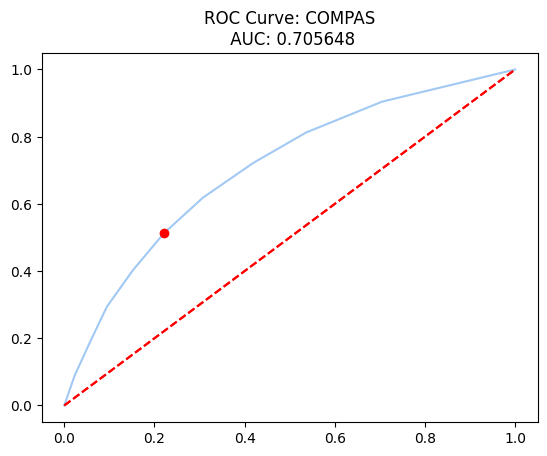

In [236]:
FTR, TPR, thresh_score = roc_curve(df['is_recid'], df['decile_score'])


ax = pd.DataFrame(TPR, index=FTR).plot(legend=False, title='ROC Curve: COMPAS\n AUC: %f' % auc(FTR, TPR))

ax.plot([FTR[5]], [TPR[5]], 'ro')
ax.plot([(0,0), (1,1)], 'r--');

### 2.6.2 - ROC Curve Decile vs Race

In [237]:
def calc_roc(x, **kwargs):
    
    FPR, TPR, thresh_score = roc_curve(x['is_recid'], x['decile_score'], **kwargs)
    return pd.DataFrame({'FPR': FPR, 'TPR': TPR, 'thresh_score': thresh_score})

a = df.groupby('race').apply(calc_roc).reset_index(level=0).reset_index(drop=True)
a_blk = a[a.race == 'African-American'].drop('race', axis=1).reset_index(drop=True)
a_wht = a[a.race == 'Caucasian'].drop('race', axis=1).reset_index(drop=True)
a_other = a[a.race == 'Other'].drop('race', axis=1).reset_index(drop=True) 

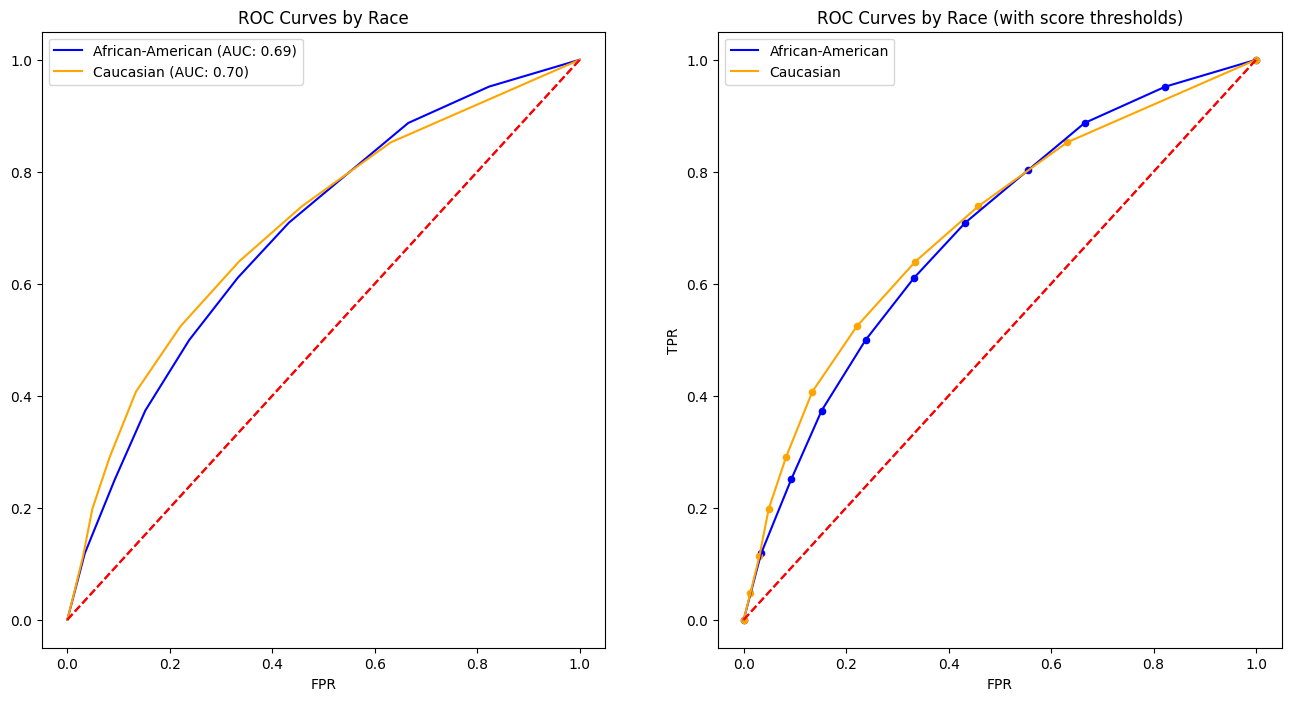

In [238]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# Plot ROC curves on the first subplot (ax1)
a_blk.plot(x='FPR', y='TPR', ax=ax1, color='blue')
a_wht.plot(x='FPR', y='TPR', ax=ax1, color='orange')

ax1.plot([(0,0), (1,1)], 'r--')

ax1.set_title('ROC Curves by Race')

# Calculate AUC for each race
auc_blk = auc(a_blk['FPR'], a_blk['TPR'])
auc_wht = auc(a_wht['FPR'], a_wht['TPR'])

# Set the legend on ax1
ax1.legend(['African-American (AUC: %0.2f)' % auc_blk, 'Caucasian (AUC: %0.2f)' % auc_wht])

# Plot ROC curves on the second subplot (ax2)
a_blk.plot(x='FPR', y='TPR', ax=ax2, label='African-American', color='blue')
a_blk.plot(kind='scatter', x='FPR', y='TPR', ax=ax2, c='blue')

a_wht.plot(x='FPR', y='TPR', ax=ax2, label='Caucasian', color='orange')
a_wht.plot(kind='scatter', x='FPR', y='TPR', ax=ax2, c='orange')


ax2.plot([(0,0), (1,1)], 'r--')

ax2.set_title('ROC Curves by Race (with score thresholds)')

# Set the legend on ax2
ax2.legend()

plt.show()


Calculating separate ROC curves by group, we see similar overall performance. However, we do see two important differences in the curves:

- The curve corresponding to the White population has higher TPR at low values of FPR
- The curve corresponding to the Black population has higher TPR at high values of FPR.

Any realistic choice of threshold (operating point) would fix a relatively low FPR, resulting in a model that performs better on the White population.

However, one sees a large difference in model characteristics when keeping track of where the score thresholds lie. The granularity of the thresholds are concentrated at opposite ends of the respective curves; the scores mean different things for the different groups.

In [239]:
pd.concat([a_wht.set_index('thresh_score'), 
           a_blk.set_index('thresh_score')],
          axis=1, keys=['Caucasian', 'African-American']).iloc[1:].style.background_gradient(cmap='viridis').format("{:.03f}")

## 2.7 Choosing a Threshold

Is there a model from these scores that may be ‘more fair’ than the existing COMPAS recommendations?

In [240]:
# Function to calculate the utility metric (accuracy score) based on threshold and weight
def calc_utility(df, thresh, wt):
    """
    Calculate utility metric (accuracy score) based on threshold and weight.

    Parameters:
    - df: DataFrame containing the data.
    - thresh: Threshold value for classification.
    - wt: Weight for positive instances in accuracy calculation.

    Returns:
    - Utility metric (accuracy score).
    """
    # Calculate accuracy score
    return accuracy_score(
        df['is_recid'],  # True labels (actual recidivism status)
        (df.decile_score >= thresh).astype(int),  # Predicted labels based on threshold
        sample_weight=df['is_recid'].replace({1: wt, 0: 1})  # Sample weights for accuracy calculation
    )

# Function to find the best threshold value that maximizes the utility metric
def find_best_thresh(df, wt=0.5):
    """
    Find the best threshold value that maximizes the utility metric.

    Parameters:
    - df: DataFrame containing the data.
    - wt: Weight for positive instances in accuracy calculation.

    Returns:
    - Best threshold value.
    """
    # Initialize variables for best threshold and utility metric
    thresh, util = 0, 0

    # Iterate over a range of threshold values
    for k in range(1, 11):
        # Calculate utility metric for the current threshold
        m = calc_utility(df, k, wt)
        # Update best threshold and utility if current utility is greater
        if m >= util:
            util = m
            thresh = k
    
    return thresh

In [241]:
find_best_thresh(df[df['race'] == 'Caucasian'], wt=0.7)

6

In [242]:
find_best_thresh(df[df['race'] == 'African-American'], wt=0.7)

7

In [243]:
# Create a DataFrame to store utility scores for different threshold and weight values
b = pd.DataFrame(
    {str(round(i,2)): [calc_utility(df, k, i) for k in range(1, 11)] for i in np.arange(0, 1.01, 0.1)}
).T

b.style.background_gradient(cmap='viridis').format("{:.03f}")

,0,1,2,3,4,5,6,7,8,9
0.0,0.000,0.295,0.464,0.581,0.693,0.779,0.848,0.905,0.942,0.977
0.1,0.084,0.347,0.493,0.593,0.686,0.756,0.810,0.854,0.879,0.902
0.2,0.156,0.390,0.518,0.603,0.681,0.737,0.778,0.810,0.825,0.839
0.3,0.216,0.427,0.539,0.612,0.677,0.721,0.751,0.773,0.780,0.785
0.4,0.269,0.459,0.558,0.619,0.673,0.707,0.728,0.741,0.740,0.738
0.5,0.315,0.487,0.574,0.625,0.669,0.695,0.707,0.713,0.705,0.697
0.6,0.356,0.512,0.588,0.631,0.666,0.684,0.689,0.688,0.675,0.661
0.7,0.392,0.534,0.600,0.636,0.664,0.675,0.673,0.666,0.648,0.629
0.8,0.424,0.554,0.612,0.641,0.661,0.666,0.659,0.646,0.623,0.600
0.9,0.453,0.571,0.622,0.645,0.659,0.658,0.646,0.628,0.602,0.574


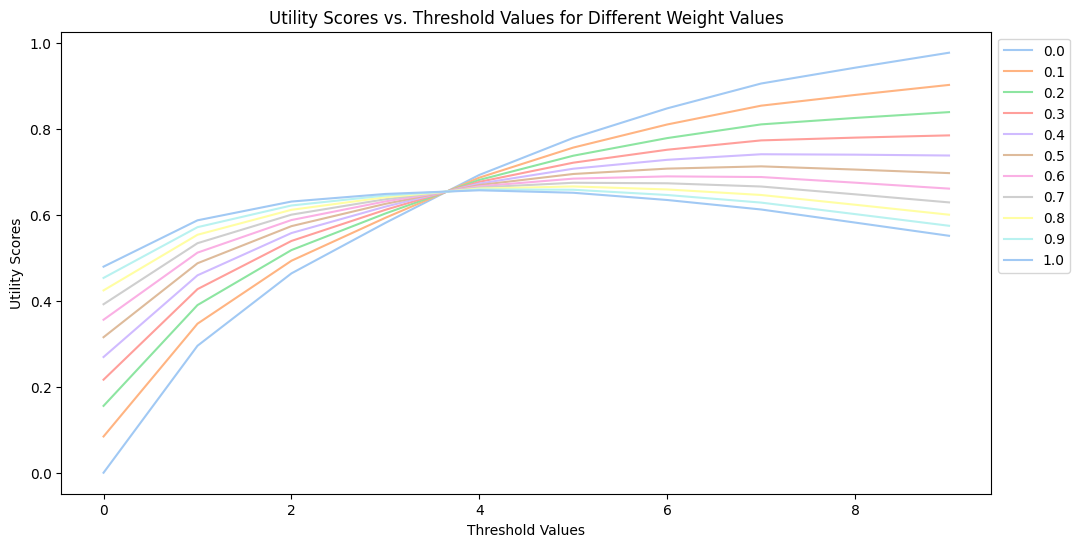

In [244]:
# Plot the transposed DataFrame 'b' with weight values on the x-axis and threshold values as different series
ax = b.T.plot(figsize=(12, 6))

# Add legend outside the plot area
ax.legend(bbox_to_anchor=(1., 1.), bbox_transform=ax.transAxes)

# Set labels for x-axis and y-axis
ax.set_xlabel('Threshold Values')
ax.set_ylabel('Utility Scores')

# Set title for the plot
ax.set_title('Utility Scores vs. Threshold Values for Different Weight Values')

# Show the plot
plt.show()

### 2.7.1 Single Threshold Model

When you give a weight of 0.5 to a particular class in a classification problem, it means that instances belonging to 

that class are considered to have half the importance or influence compared to instances belonging to the other class.

In your context, the weight parameter (wt) is used in the calc_utility function to adjust the sample weight for positive 
instances (where is_recid equals 1) in the accuracy calculation.

- If wt is set to 0.5, it means that positive instances are given half the weight of negative instances in the accuracy calculation. 
This implies that the model's performance is evaluated with equal importance placed on correctly predicting both positive and negative instances.

- If wt is set to a value higher than 0.5, it means that positive instances are given more weight or importance compared to negative instances. 
This could be useful if correctly predicting positive instances is more crucial for your task.

- If wt is set to a value lower than 0.5, it means that positive instances are given less weight or importance compared to negative instances. 
This could be appropriate if you want to prioritize correctly predicting negative instances.

By adjusting the weight parameter, you can control how much importance is given to different types of predictions in your evaluation metric.

In [245]:
# single best threhold
find_best_thresh(df,wt=0.7)

6

### 2.7.2 What thresholds yield the best model, subject to Demographic Parity

In [246]:
sc = df.copy()
for tw in range(1,11):
    for tb in range(1,11):
        sc.loc[sc.race == 'Caucasian', 'decision_%d_%d' %(tw, tb)] = (sc.loc[sc.race == 'Caucasian', 'decile_score'] >= tw).astype(int)
        sc.loc[sc.race == 'African-American', 'decision_%d_%d' %(tw, tb)] = (sc.loc[sc.race == 'African-American', 'decile_score'] >= tb).astype(int)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_8772\2909636715.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sc.loc[sc.race == 'Caucasian', 'decision_%d_%d' %(tw, tb)] = (sc.loc[sc.race == 'Caucasian', 'decile_score'] >= tw).astype(int)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_8772\2909636715.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sc.loc[sc.race == 'Caucasian', 'decision_%d_%d' %(tw, tb)] = (sc.loc[sc.race == 'Caucasian', 'decile_score'] >= tw).astype(int)
C:\Users\Utilizador\AppData\Local\Temp\ipyke

In [247]:
sc.head()

,sex,race,c_charge_degree,juv_fel_count,juv_misd_count,juv_other_count,priors_count,decile_score,score_text,v_decile_score,v_score_text,is_recid,r_charge_degree,is_violent_recid,vr_charge_degree,two_year_recid,age_group,jail_time_days,time_between_arrest_screening,pred_baseline,pred_baseline_prob,decision_1_1,decision_1_2,decision_1_3,decision_1_4,decision_1_5,decision_1_6,decision_1_7,decision_1_8,decision_1_9,decision_1_10,decision_2_1,decision_2_2,decision_2_3,decision_2_4,decision_2_5,decision_2_6,decision_2_7,decision_2_8,decision_2_9,decision_2_10,decision_3_1,decision_3_2,decision_3_3,decision_3_4,decision_3_5,decision_3_6,decision_3_7,decision_3_8,decision_3_9,decision_3_10,decision_4_1,decision_4_2,decision_4_3,decision_4_4,decision_4_5,decision_4_6,decision_4_7,decision_4_8,decision_4_9,decision_4_10,decision_5_1,decision_5_2,decision_5_3,decision_5_4,decision_5_5,decision_5_6,decision_5_7,decision_5_8,decision_5_9,decision_5_10,decision_6_1,decision_6_2,decision_6_3,decision_6_4,decision_6_5,decision_6_6,decision_6_7,decision_6_8,decision_6_9,decision_6_10,decision_7_1,decision_7_2,decision_7_3,decision_7_4,decision_7_5,decision_7_6,decision_7_7,decision_7_8,decision_7_9,decision_7_10,decision_8_1,decision_8_2,decision_8_3,decision_8_4,decision_8_5,decision_8_6,decision_8_7,decision_8_8,decision_8_9,decision_8_10,decision_9_1,decision_9_2,decision_9_3,decision_9_4,decision_9_5,decision_9_6,decision_9_7,decision_9_8,decision_9_9,decision_9_10,decision_10_1,decision_10_2,decision_10_3,decision_10_4,decision_10_5,decision_10_6,decision_10_7,decision_10_8,decision_10_9,decision_10_10
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Male,Caucasian,Felony,0,0,0,0,1,Low,1,Low,0,Missing,0,Missing,0,55+,1.0,NaN,0,0.000095,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Male,African-American,Misdemeanor,0,0,0,1,3,Low,3,Low,0,Missing,0,Missing,0,25-34,1.0,NaN,0,0.000113,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Male,African-American,Misdemeanor,0,0,0,8,4,Low,2,Low,1,Misdemeanor,0,Missing,1,55+,-1.0,NaN,1,0.983916,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Male,African-American,Felony,0,1,0,1,10,High,10,High,1,Misdemeanor,0,Missing,1,<25,-1.0,0.0,1,0.997982,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,Female,Other,Misdemeanor,0,0,0,0,1,Low,1,Low,0,Missing,0,Missing,0,35-44,1.0,NaN,0,0.000111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [248]:
demos = sc[['race'] + [x for x in sc.columns if 'decision_' in x]].groupby('race').mean().T[['African-American','Caucasian']]
demos

race,African-American,Caucasian
decision_1_1,1.000000,1.000000
decision_1_2,0.893624,1.000000
decision_1_3,0.786607,1.000000
decision_1_4,0.690484,1.000000
decision_1_5,0.583787,1.000000
...,...,...
decision_10_6,0.484781,0.027844
decision_10_7,0.380968,0.027844
decision_10_8,0.273310,0.027844
decision_10_9,0.179109,0.027844


In [249]:
# Calculate the difference in decision rates between African-American and Caucasian groups
(demos['African-American'] - demos['Caucasian']).sort_values().loc[lambda x:(-0.02 <= x) & (x <= 0.02)]

decision_1_1     0.000000
decision_3_5     0.008655
decision_7_9     0.009162
decision_9_10    0.014812
dtype: float64

In [250]:
# Calculate the difference in decision rates between African-American and Caucasian groups
def weighted_accuracy(df, col, wt=0.7):

    return accuracy_score(
        df['is_recid'], 
        col, 
        sample_weight=df['is_recid'].replace({1: wt, 0:1})
    )
    
# Define a condition for filtering
condition = (sc['race'] == 'African-American') | (sc['race'] == 'Caucasian')

# Filter the DataFrame based on the condition
filtered_sc = sc[condition]

# Apply weighted_accuracy function to each decision column
result = (
    filtered_sc
    .loc[:, [x for x in filtered_sc.columns if 'decision_' in x]]
    .apply(lambda x: weighted_accuracy(filtered_sc, x))
    .sort_values(ascending=False)
)

result

decision_6_7     0.670587
decision_6_6     0.670362
decision_7_7     0.668465
decision_7_6     0.668239
decision_6_5     0.665079
                   ...   
decision_2_1     0.488351
decision_1_3     0.484332
decision_1_10    0.478214
decision_1_2     0.451528
decision_1_1     0.408046
Length: 100, dtype: float64

In [251]:
pd.DataFrame(result, columns=['Accuracy']).head(5).style.background_gradient(cmap='viridis').format("{:.03f}")

,Accuracy
decision_6_7,0.671
decision_6_6,0.670
decision_7_7,0.668
decision_7_6,0.668
decision_6_5,0.665


In [252]:
df.columns

Index(['sex', 'race', 'c_charge_degree', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'decile_score', 'score_text',
       'v_decile_score', 'v_score_text', 'is_recid', 'r_charge_degree',
       'is_violent_recid', 'vr_charge_degree', 'two_year_recid', 'age_group',
       'jail_time_days', 'time_between_arrest_screening', 'pred_baseline',
       'pred_baseline_prob'],
      dtype='object')

# 3) Serialize the model and the preprocessor pipeline

In [253]:
with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)
    
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
with open('pipeline.pickle', 'wb') as fh:
    pickle.dump(pipeline, fh)

In [254]:
# Deserialize the Model
with open('columns.json', 'r') as fh:
    columns = json.load(fh)
columns

['sex',
 'race',
 'c_charge_degree',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'decile_score',
 'score_text',
 'v_decile_score',
 'v_score_text',
 'r_charge_degree',
 'vr_charge_degree',
 'age_group',
 'jail_time_days',
 'time_between_arrest_screening']

In [255]:
with open('dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)
dtypes

sex                                object
race                               object
c_charge_degree                    object
juv_fel_count                       int64
juv_misd_count                      int64
juv_other_count                     int64
priors_count                        int64
decile_score                        int64
score_text                         object
v_decile_score                      int64
v_score_text                       object
r_charge_degree                    object
vr_charge_degree                   object
age_group                        category
jail_time_days                    float64
time_between_arrest_screening     float64
dtype: object

In [256]:
pipeline = joblib.load('baseline_pipeline.pickle')
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
       'decile_score', 'v_decile_score', 'jail_time_days',
       'time_between_arrest_screening'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['sex', 'race', 'c_charge_degree', 'score_text', 'v_score_text',
       'r_charge_degree', 'vr_charge_degree', 'age_group'],
      dtype='object'))])),
                ('classifier',
                 LGBMClassifier(force_col_wise=True, n_jobs=-1,
                                random_state=42))])

In [257]:
df.age_group.value_counts()

age_group
25-34    2473
35-44    1244
<25       977
45-54     855
55+       565
Name: count, dtype: int64

In [258]:
new_obs_str = '{' + '''
    "sex":"Male",
    "race":"African-American",
    "c_charge_degree":"Misdemeanor",
    "juv_fel_count":0,
    "juv_misd_count":2,
    "juv_other_count":3,
    "priors_count":5,
    "decile_score":8,
    "score_text":"High",
    "v_decile_score":8,
    "v_score_text":"High",
    "r_charge_degree":"Misdemeanor",
    "vr_charge_degree":"Missing",
    "age_group":"55+",
    "jail_time_days":32,
    "time_between_arrest_screening":3
''' + '}'

new_obs_dict = json.loads(new_obs_str)
obs = pd.DataFrame([new_obs_dict], columns=columns)
obs = obs.astype(dtypes)

In [259]:
obs

,sex,race,c_charge_degree,juv_fel_count,juv_misd_count,juv_other_count,priors_count,decile_score,score_text,v_decile_score,v_score_text,r_charge_degree,vr_charge_degree,age_group,jail_time_days,time_between_arrest_screening
0,Male,African-American,Misdemeanor,0,2,3,5,8,High,8,High,Misdemeanor,Missing,55+,32.0,3.0


In [260]:
outcome = pipeline.predict_proba(obs)
outcome

array([[0.00182495, 0.99817505]])

In [263]:
# there's only a single observation... so yeah
observation_index = 0
# This is the trick, go for the the positive class index
positive_class_index = 1
# Indexing in numpy arrays is a bit different than in normal
# python arrays:
recidivism_probability = outcome[observation_index, positive_class_index]
print('The observation has {} probability of two_year_recid.'.format(recidivism_probability))

The observation has 0.9981750486143541 probability of two_year_recid.
